In [1]:
from utils.epg import *
import matplotlib.pyplot as plt
from copy import copy
cmap = copy(plt.cm.get_cmap("jet"))
from scipy.optimize import least_squares

In [2]:
degree = r"${}^{\circ}$"
GeV = "GeV"
GeV2 = "GeV"+r"${}^{2}$"
GeVc = "GeV/c"
GeVc2 = "(GeV/c)"+r"${}^{2}$"

In [3]:
import matplotlib
# initial settings
pgf_with_latex = {
		"pgf.texsystem": "pdflatex",
		"text.usetex": True,            # use LaTeX to write all text
		"font.family": "sans-serif",         
		"font.sans-serif": "Helvetica",
		"font.size": 25,				# default font size
		"axes.labelsize": 24,			# x and y label size
		"axes.titlesize": 24,           # subfigure title size, i.e. title size when one figure
		"legend.fontsize": 22,			# legend size
		"xtick.labelsize": 23,			# x axis tick label size
		"ytick.labelsize": 23,			# y axis tick label 
		"figure.titlesize": 25,         # Figure title size, useful when you have multiple plots in one canvas.
		"pgf.preamble": r"\usepackage{xcolor}",     # xcolor for colours
		"figure.autolayout": True
}
matplotlib.rcParams.update(pgf_with_latex)

def nphistmean(hist, bins):
    s=0
    for i in range(len(hist)):
        s += hist[i] * ((bins[i] + bins[i+1]) / 2) 
    mean = s / np.sum(hist)
    return mean

In [4]:
def reDefineDVCS(df_epg):

    df_epg.loc[:, 'newPe'] = df_epg.t2/2/M + M
    df_epg.loc[:, 'newPp'] = np.sqrt(df_epg.newPe**2 - M**2)
    df_epg.loc[:, 'newGp'] = df_epg.nu - df_epg.t2/M/2
    
    df_epg.loc[:, 'dPp'] = df_epg.loc[:, 'newPp'] -  df_epg.loc[:, 'Pp']
    df_epg.loc[:, 'dGp'] = df_epg.loc[:, 'newGp'] -  df_epg.loc[:, 'Gp']

    return df_epg

In [239]:
parent_MC = "/Volumes/Extreme SSD/nov2021/convPkl/dvcs/"
parent_MC_bkg1g = "/Volumes/Extreme SSD/nov2021/convPkl/bkg_1g/"
parent_MC_bkg2g = "/Volumes/Extreme SSD/nov2021/convPkl/bkg_2g/"
parent_exp = "/Volumes/Extreme SSD/nov2021/convPkl/exp/"

# df_3063_corr = pd.read_pickle(parent_MC + "3063.pkl")
df_3987_corr = pd.read_pickle(parent_MC + "3987.pkl")
# df_3284_1g_corr = pd.read_pickle(parent_MC_bkg1g + "3284.pkl")
# df_3284_2g_corr = pd.read_pickle(parent_MC_bkg2g + "3284.pkl")
df_4076_1g_corr = pd.read_pickle(parent_MC_bkg1g + "4076.pkl")
df_4076_2g_corr = pd.read_pickle(parent_MC_bkg2g + "4076.pkl")
exp_1g_corr = pd.read_pickle(parent_exp + "dvcs.pkl")
exp_2g_corr = pd.read_pickle(parent_exp + "pi0.pkl")

In [240]:
epgExpInb = copy(exp_1g_corr)
pi0ExpInb = copy(exp_2g_corr)
dvcsSimInb = copy(df_3987_corr)
bkgSimInb = copy(df_4076_1g_corr)
pi0SimInb = copy(df_4076_2g_corr)


In [241]:
epgExpInbCDFT = epgExpInb.loc[(exp_1g_corr.Ee>2)&(exp_1g_corr.Ge>3)&(exp_1g_corr.Pp>0.25)&(exp_1g_corr.Pp<0.8)&((exp_1g_corr.Psector>7)&(exp_1g_corr.Ptheta<60))& (exp_1g_corr.Gsector>7)]
pi0ExpInbCDFT = pi0ExpInb.loc[(exp_2g_corr.Ee>2)&(exp_2g_corr.Ge>3)&(exp_2g_corr.Pp>0.25)&(exp_2g_corr.Pp<0.8)&((exp_2g_corr.Psector>7)&(exp_2g_corr.Ptheta<60))& (exp_2g_corr.Gsector>7)& (exp_2g_corr.Gsector2>7)]
dvcsSimInbCDFT = dvcsSimInb.loc[(dvcsSimInb.Ee>2)&(dvcsSimInb.Ge>3)&(dvcsSimInb.Pp>0.25)&(dvcsSimInb.Pp<0.8)&((dvcsSimInb.Psector>7)&(dvcsSimInb.Ptheta<60))& (dvcsSimInb.Gsector>7)]
bkgSimInbCDFT = bkgSimInb.loc[(bkgSimInb.Ee>2)&(bkgSimInb.Ge>3)&(bkgSimInb.Pp>0.25)&(bkgSimInb.Pp<0.8)&((bkgSimInb.Psector>7)&(bkgSimInb.Ptheta<60))& (bkgSimInb.Gsector>7)]
pi0SimInbCDFT = pi0SimInb.loc[(pi0SimInb.Ee>2)&(pi0SimInb.Ge>3)&(pi0SimInb.Pp>0.25)&(pi0SimInb.Pp<0.8)&((pi0SimInb.Psector>7)&(pi0SimInb.Ptheta<60))& (pi0SimInb.Gsector>7)]

In [96]:
def correctDVCS(df_epg, correction=0):
    #set up dvcs variables
    df_epg = copy(df_epg)

    ele = [df_epg['Epx'], df_epg['Epy'], df_epg['Epz']]
#     df_epg.loc[:, 'Ep'] = mag(ele)
#     df_epg.loc[:, 'Ee'] = getEnergy(ele, me)
#     df_epg.loc[:, 'Etheta'] = getTheta(ele)
#     df_epg.loc[:, 'Ephi'] = getPhi(ele)

    pro = [df_epg['Ppx'], df_epg['Ppy'], df_epg['Ppz']]
#     df_epg.loc[:, 'Pp'] = mag(pro)
#     df_epg.loc[:, 'Pe'] = getEnergy(pro, 0)
#     df_epg.loc[:, 'Ptheta'] = getTheta(pro)
#     df_epg.loc[:, 'Pphi'] = getPhi(pro)

    df_epg.loc[df_epg.Gsector>7, 'Gp'] = df_epg.loc[df_epg.Gsector>7, 'Gp'] + correction
    df_epg.loc[df_epg.Gsector>7, 'Ge'] = df_epg.loc[df_epg.Gsector>7, 'Ge'] + correction
#     df_epg.loc[:, 'Gtheta'] = getTheta(gam)
#     df_epg.loc[:, 'Gphi'] = getPhi(gam)
    df_epg.loc[:, "Gpx"] = df_epg.loc[:, "Gp"]*np.sin(np.radians(df_epg.loc[:, "Gtheta"]))*np.cos(np.radians(df_epg.loc[:, "Gphi"]))
    df_epg.loc[:, "Gpy"] = df_epg.loc[:, "Gp"]*np.sin(np.radians(df_epg.loc[:, "Gtheta"]))*np.sin(np.radians(df_epg.loc[:, "Gphi"]))
    df_epg.loc[:, "Gpz"] = df_epg.loc[:, "Gp"]*np.cos(np.radians(df_epg.loc[:, "Gtheta"]))
    gam = [df_epg['Gpx'], df_epg['Gpy'], df_epg['Gpz']]

    Ppt = mag([df_epg['Ppx'], df_epg['Ppy'], 0])

    VGS = [-df_epg['Epx'], -df_epg['Epy'], pbeam - df_epg['Epz']]
    v3l = cross(beam, ele)
    v3h = cross(pro, VGS)
    v3g = cross(VGS, gam)
    VmissG = [-df_epg["Epx"] - df_epg["Ppx"], -df_epg["Epy"] - df_epg["Ppy"],
              pbeam - df_epg["Epz"] - df_epg["Ppz"]]
    VmissP = [-(df_epg["Epx"] + df_epg["Gpx"]), -(df_epg["Epy"] + df_epg["Gpy"]),
              -(-pbeam + df_epg["Epz"] + df_epg["Gpz"])]
    Vmiss = [-(df_epg["Epx"] + df_epg["Ppx"] + df_epg["Gpx"]), -(df_epg["Epy"] + df_epg["Ppy"] + df_epg["Gpy"]),
             -(-pbeam + df_epg["Epz"] + df_epg["Ppz"] + df_epg["Gpz"])]
    costheta = cosTheta(VGS, gam)

    df_epg.loc[:, 'Mpx'], df_epg.loc[:, 'Mpy'], df_epg.loc[:, 'Mpz'] = Vmiss

    # binning kinematics
    df_epg.loc[:,'Q2'] = -((ebeam - df_epg['Ee'])**2 - mag2(VGS))
    df_epg.loc[:,'nu'] = (ebeam - df_epg['Ee'])
    df_epg.loc[:,'y'] = df_epg['nu']/ebeam
    df_epg.loc[:,'xB'] = df_epg['Q2'] / 2.0 / M / df_epg['nu']
    df_epg.loc[:,'t1'] = 2 * M * (df_epg['Pe'] - M)
    df_epg.loc[:,'t2'] = (M * df_epg['Q2'] + 2 * M * df_epg['nu'] * (df_epg['nu'] - np.sqrt(df_epg['nu'] * df_epg['nu'] + df_epg['Q2']) * costheta))\
    / (M + df_epg['nu'] - np.sqrt(df_epg['nu'] * df_epg['nu'] + df_epg['Q2']) * costheta)
    df_epg.loc[:,'W'] = np.sqrt(np.maximum(0, (ebeam + M - df_epg['Ee'])**2 - mag2(VGS)))

    # trento angles
    df_epg.loc[:,'phi1'] = angle(v3l, v3h)
    df_epg.loc[:,'phi1'] = np.where(dot(v3l, pro) > 0, 360.0 -
                              df_epg['phi1'], df_epg['phi1'])
    df_epg.loc[:,'phi2'] = angle(v3l, v3g)
    df_epg.loc[:,'phi2'] = np.where(dot(v3l, gam) <
                              0, 360.0 - df_epg['phi2'], df_epg['phi2'])

    # exclusivity variables
    df_epg.loc[:,'MM2_epg'] = (-M - ebeam + df_epg["Ee"] +
                         df_epg["Pe"] + df_epg["Ge"])**2 - mag2(Vmiss)
    df_epg.loc[:,'ME_epg'] = (M + ebeam - df_epg["Ee"] - df_epg["Pe"] - df_epg["Ge"])
    df_epg.loc[:,'MM2_ep'] = (-M - ebeam + df_epg["Ee"] + df_epg["Pe"])**2 - mag2(VmissG)
    df_epg.loc[:,'MM2_eg'] = (-M - ebeam + df_epg["Ee"] + df_epg["Ge"])**2 - mag2(VmissP)
    df_epg.loc[:,'MPt'] = np.sqrt((df_epg["Epx"] + df_epg["Ppx"] + df_epg["Gpx"])**2 +
                            (df_epg["Epy"] + df_epg["Ppy"] + df_epg["Gpy"])**2)
    df_epg.loc[:,'coneAngle'] = angle(ele, gam)
    df_epg.loc[:,'reconGam'] = angle(gam, VmissG)
    df_epg.loc[:,'coplanarity'] = angle(v3h, v3g)
    
    return df_epg


In [873]:
def smearingDVCS(df_epg, sigma = 0, sigma2 = 0, sigma3 = 0):
    #set up dvcs variables
    df_epg = copy(df_epg)

    ele = [df_epg['Epx'], df_epg['Epy'], df_epg['Epz']]
#     df_epg.loc[:, 'Ep'] = mag(ele)
#     df_epg.loc[:, 'Ee'] = getEnergy(ele, me)
#     df_epg.loc[:, 'Etheta'] = getTheta(ele)
#     df_epg.loc[:, 'Ephi'] = getPhi(ele)

    pro = [df_epg['Ppx'], df_epg['Ppy'], df_epg['Ppz']]
#     df_epg.loc[:, 'Pp'] = mag(pro)
#     df_epg.loc[:, 'Pe'] = getEnergy(pro, 0)
#     df_epg.loc[:, 'Ptheta'] = getTheta(pro)
#     df_epg.loc[:, 'Pphi'] = getPhi(pro)

    df_epg.loc[df_epg.Gsector>7, 'Gp'] = np.random.normal(1, sigma, len(df_epg.loc[df_epg.Gsector>7]))*df_epg.loc[df_epg.Gsector>7, 'Gp']
    df_epg.loc[df_epg.Gsector>7, 'Gtheta'] = np.random.normal(0, sigma2, len(df_epg.loc[df_epg.Gsector>7]))+df_epg.loc[df_epg.Gsector>7, 'Gtheta']
    df_epg.loc[df_epg.Gsector>7, 'Gphi'] = np.random.normal(0, sigma3, len(df_epg.loc[df_epg.Gsector>7]))+df_epg.loc[df_epg.Gsector>7, 'Gphi']
    df_epg.loc[df_epg.Gsector>7, 'Ge'] = df_epg.loc[df_epg.Gsector>7, 'Gp']
#     df_epg.loc[:, 'Gtheta'] = getTheta(gam)
#     df_epg.loc[:, 'Gphi'] = getPhi(gam)
    df_epg.loc[:, "Gpx"] = df_epg.loc[:, "Gp"]*np.sin(np.radians(df_epg.loc[:, "Gtheta"]))*np.cos(np.radians(df_epg.loc[:, "Gphi"]))
    df_epg.loc[:, "Gpy"] = df_epg.loc[:, "Gp"]*np.sin(np.radians(df_epg.loc[:, "Gtheta"]))*np.sin(np.radians(df_epg.loc[:, "Gphi"]))
    df_epg.loc[:, "Gpz"] = df_epg.loc[:, "Gp"]*np.cos(np.radians(df_epg.loc[:, "Gtheta"]))
    gam = [df_epg['Gpx'], df_epg['Gpy'], df_epg['Gpz']]
    
    Ppt = mag([df_epg['Ppx'], df_epg['Ppy'], 0])

    VGS = [-df_epg['Epx'], -df_epg['Epy'], pbeam - df_epg['Epz']]
    v3l = cross(beam, ele)
    v3h = cross(pro, VGS)
    v3g = cross(VGS, gam)
    VmissG = [-df_epg["Epx"] - df_epg["Ppx"], -df_epg["Epy"] - df_epg["Ppy"],
              pbeam - df_epg["Epz"] - df_epg["Ppz"]]
    VmissP = [-(df_epg["Epx"] + df_epg["Gpx"]), -(df_epg["Epy"] + df_epg["Gpy"]),
              -(-pbeam + df_epg["Epz"] + df_epg["Gpz"])]
    Vmiss = [-(df_epg["Epx"] + df_epg["Ppx"] + df_epg["Gpx"]), -(df_epg["Epy"] + df_epg["Ppy"] + df_epg["Gpy"]),
             -(-pbeam + df_epg["Epz"] + df_epg["Ppz"] + df_epg["Gpz"])]
    costheta = cosTheta(VGS, gam)

    df_epg.loc[:, 'Mpx'], df_epg.loc[:, 'Mpy'], df_epg.loc[:, 'Mpz'] = Vmiss

    # binning kinematics
    df_epg.loc[:,'Q2'] = -((ebeam - df_epg['Ee'])**2 - mag2(VGS))
    df_epg.loc[:,'nu'] = (ebeam - df_epg['Ee'])
    df_epg.loc[:,'y'] = df_epg['nu']/ebeam
    df_epg.loc[:,'xB'] = df_epg['Q2'] / 2.0 / M / df_epg['nu']
    df_epg.loc[:,'t1'] = 2 * M * (df_epg['Pe'] - M)
    df_epg.loc[:,'t2'] = (M * df_epg['Q2'] + 2 * M * df_epg['nu'] * (df_epg['nu'] - np.sqrt(df_epg['nu'] * df_epg['nu'] + df_epg['Q2']) * costheta))\
    / (M + df_epg['nu'] - np.sqrt(df_epg['nu'] * df_epg['nu'] + df_epg['Q2']) * costheta)
    df_epg.loc[:,'W'] = np.sqrt(np.maximum(0, (ebeam + M - df_epg['Ee'])**2 - mag2(VGS)))

    # trento angles
    df_epg.loc[:,'phi1'] = angle(v3l, v3h)
    df_epg.loc[:,'phi1'] = np.where(dot(v3l, pro) > 0, 360.0 -
                              df_epg['phi1'], df_epg['phi1'])
    df_epg.loc[:,'phi2'] = angle(v3l, v3g)
    df_epg.loc[:,'phi2'] = np.where(dot(v3l, gam) <
                              0, 360.0 - df_epg['phi2'], df_epg['phi2'])

    # exclusivity variables
    df_epg.loc[:,'MM2_epg'] = (-M - ebeam + df_epg["Ee"] +
                         df_epg["Pe"] + df_epg["Ge"])**2 - mag2(Vmiss)
    df_epg.loc[:,'ME_epg'] = (M + ebeam - df_epg["Ee"] - df_epg["Pe"] - df_epg["Ge"])
    df_epg.loc[:,'MM2_ep'] = (-M - ebeam + df_epg["Ee"] + df_epg["Pe"])**2 - mag2(VmissG)
    df_epg.loc[:,'MM2_eg'] = (-M - ebeam + df_epg["Ee"] + df_epg["Ge"])**2 - mag2(VmissP)
    df_epg.loc[:,'MPt'] = np.sqrt((df_epg["Epx"] + df_epg["Ppx"] + df_epg["Gpx"])**2 +
                            (df_epg["Epy"] + df_epg["Ppy"] + df_epg["Gpy"])**2)
    df_epg.loc[:,'coneAngle'] = angle(ele, gam)
    df_epg.loc[:,'reconGam'] = angle(gam, VmissG)
    df_epg.loc[:,'coplanarity'] = angle(v3h, v3g)
    
    return df_epg


In [391]:
def correctDVCS2(df_epg, correction=0, correction2 =0, correction3=0):
    #set up dvcs variables
    df_epg = copy(df_epg)

    ele = [df_epg['Epx'], df_epg['Epy'], df_epg['Epz']]
#     df_epg.loc[:, 'Ep'] = mag(ele)
#     df_epg.loc[:, 'Ee'] = getEnergy(ele, me)
#     df_epg.loc[:, 'Etheta'] = getTheta(ele)
#     df_epg.loc[:, 'Ephi'] = getPhi(ele)

    df_epg.loc[df_epg.Psector>7, 'Pp'] = df_epg.loc[df_epg.Psector>7, 'Pp'] + correction
    df_epg.loc[df_epg.Psector>7, 'Pe'] = np.sqrt(df_epg.loc[df_epg.Psector>7, 'Pp']**2+M**2)
    df_epg.loc[df_epg.Psector>7, 'Ptheta'] = df_epg.loc[df_epg.Psector>7, 'Ptheta'] + correction2
    df_epg.loc[df_epg.Psector>7, 'Pphi'] = df_epg.loc[df_epg.Psector>7, 'Pphi'] + correction3
    df_epg.loc[:, "Ppx"] = df_epg.loc[:, "Pp"]*np.sin(np.radians(df_epg.loc[:, "Ptheta"]))*np.cos(np.radians(df_epg.loc[:, "Pphi"]))
    df_epg.loc[:, "Ppy"] = df_epg.loc[:, "Pp"]*np.sin(np.radians(df_epg.loc[:, "Ptheta"]))*np.sin(np.radians(df_epg.loc[:, "Pphi"]))
    df_epg.loc[:, "Ppz"] = df_epg.loc[:, "Pp"]*np.cos(np.radians(df_epg.loc[:, "Ptheta"]))
    pro = [df_epg['Ppx'], df_epg['Ppy'], df_epg['Ppz']]
    
#     df_epg.loc[df_epg.Gsector>7, 'Gp'] = df_epg.loc[df_epg.Gsector>7, 'Gp'] + 0.25
#     df_epg.loc[df_epg.Gsector>7, 'Ge'] = df_epg.loc[df_epg.Gsector>7, 'Ge'] + 0.25
# #     df_epg.loc[:, 'Gtheta'] = getTheta(gam)
# #     df_epg.loc[:, 'Gphi'] = getPhi(gam)
#     df_epg.loc[:, "Gpx"] = df_epg.loc[:, "Gp"]*np.sin(np.radians(df_epg.loc[:, "Gtheta"]))*np.cos(np.radians(df_epg.loc[:, "Gphi"]))
#     df_epg.loc[:, "Gpy"] = df_epg.loc[:, "Gp"]*np.sin(np.radians(df_epg.loc[:, "Gtheta"]))*np.sin(np.radians(df_epg.loc[:, "Gphi"]))
#     df_epg.loc[:, "Gpz"] = df_epg.loc[:, "Gp"]*np.cos(np.radians(df_epg.loc[:, "Gtheta"]))
    gam = [df_epg['Gpx'], df_epg['Gpy'], df_epg['Gpz']]

    Ppt = mag([df_epg['Ppx'], df_epg['Ppy'], 0])

    VGS = [-df_epg['Epx'], -df_epg['Epy'], pbeam - df_epg['Epz']]
    v3l = cross(beam, ele)
    v3h = cross(pro, VGS)
    v3g = cross(VGS, gam)
    VmissG = [-df_epg["Epx"] - df_epg["Ppx"], -df_epg["Epy"] - df_epg["Ppy"],
              pbeam - df_epg["Epz"] - df_epg["Ppz"]]
    VmissP = [-(df_epg["Epx"] + df_epg["Gpx"]), -(df_epg["Epy"] + df_epg["Gpy"]),
              -(-pbeam + df_epg["Epz"] + df_epg["Gpz"])]
    Vmiss = [-(df_epg["Epx"] + df_epg["Ppx"] + df_epg["Gpx"]), -(df_epg["Epy"] + df_epg["Ppy"] + df_epg["Gpy"]),
             -(-pbeam + df_epg["Epz"] + df_epg["Ppz"] + df_epg["Gpz"])]
    costheta = cosTheta(VGS, gam)

    df_epg.loc[:, 'Mpx'], df_epg.loc[:, 'Mpy'], df_epg.loc[:, 'Mpz'] = Vmiss

    # binning kinematics
    df_epg.loc[:,'Q2'] = -((ebeam - df_epg['Ee'])**2 - mag2(VGS))
    df_epg.loc[:,'nu'] = (ebeam - df_epg['Ee'])
    df_epg.loc[:,'y'] = df_epg['nu']/ebeam
    df_epg.loc[:,'xB'] = df_epg['Q2'] / 2.0 / M / df_epg['nu']
    df_epg.loc[:,'t1'] = 2 * M * (df_epg['Pe'] - M)
    df_epg.loc[:,'t2'] = (M * df_epg['Q2'] + 2 * M * df_epg['nu'] * (df_epg['nu'] - np.sqrt(df_epg['nu'] * df_epg['nu'] + df_epg['Q2']) * costheta))\
    / (M + df_epg['nu'] - np.sqrt(df_epg['nu'] * df_epg['nu'] + df_epg['Q2']) * costheta)
    df_epg.loc[:,'W'] = np.sqrt(np.maximum(0, (ebeam + M - df_epg['Ee'])**2 - mag2(VGS)))

    # trento angles
    df_epg.loc[:,'phi1'] = angle(v3l, v3h)
    df_epg.loc[:,'phi1'] = np.where(dot(v3l, pro) > 0, 360.0 -
                              df_epg['phi1'], df_epg['phi1'])
    df_epg.loc[:,'phi2'] = angle(v3l, v3g)
    df_epg.loc[:,'phi2'] = np.where(dot(v3l, gam) <
                              0, 360.0 - df_epg['phi2'], df_epg['phi2'])

    # exclusivity variables
    df_epg.loc[:,'MM2_epg'] = (-M - ebeam + df_epg["Ee"] +
                         df_epg["Pe"] + df_epg["Ge"])**2 - mag2(Vmiss)
    df_epg.loc[:,'ME_epg'] = (M + ebeam - df_epg["Ee"] - df_epg["Pe"] - df_epg["Ge"])
    df_epg.loc[:,'MM2_ep'] = (-M - ebeam + df_epg["Ee"] + df_epg["Pe"])**2 - mag2(VmissG)
    df_epg.loc[:,'MM2_eg'] = (-M - ebeam + df_epg["Ee"] + df_epg["Ge"])**2 - mag2(VmissP)
    df_epg.loc[:,'MPt'] = np.sqrt((df_epg["Epx"] + df_epg["Ppx"] + df_epg["Gpx"])**2 +
                            (df_epg["Epy"] + df_epg["Ppy"] + df_epg["Gpy"])**2)
    df_epg.loc[:,'coneAngle'] = angle(ele, gam)
    df_epg.loc[:,'reconGam'] = angle(gam, VmissG)
    df_epg.loc[:,'coplanarity'] = angle(v3h, v3g)
    
    return df_epg


In [887]:
def smearingDVCS2(df_epg, sigma = 0, sigma2 = 0, sigma3 = 0):
    #set up dvcs variables
    df_epg = copy(df_epg)

    ele = [df_epg['Epx'], df_epg['Epy'], df_epg['Epz']]
#     df_epg.loc[:, 'Ep'] = mag(ele)
#     df_epg.loc[:, 'Ee'] = getEnergy(ele, me)
#     df_epg.loc[:, 'Etheta'] = getTheta(ele)
#     df_epg.loc[:, 'Ephi'] = getPhi(ele)

    df_epg.loc[df_epg.Psector>7, 'Pp'] = np.random.normal(1, sigma, len(df_epg.loc[df_epg.Psector>7]))*df_epg.loc[df_epg.Psector>7, 'Pp']
    df_epg.loc[df_epg.Psector>7, 'Ptheta'] = np.random.normal(0, sigma2, len(df_epg.loc[df_epg.Psector>7]))+df_epg.loc[df_epg.Psector>7, 'Ptheta']
    df_epg.loc[df_epg.Psector>7, 'Pphi'] = np.random.normal(0, sigma3, len(df_epg.loc[df_epg.Psector>7]))+df_epg.loc[df_epg.Psector>7, 'Pphi']
    df_epg.loc[df_epg.Psector>7, 'Pe'] = np.sqrt(df_epg.loc[df_epg.Psector>7, 'Pp']**2+M**2)
    df_epg.loc[:, "Ppx"] = df_epg.loc[:, "Pp"]*np.sin(np.radians(df_epg.loc[:, "Ptheta"]))*np.cos(np.radians(df_epg.loc[:, "Pphi"]))
    df_epg.loc[:, "Ppy"] = df_epg.loc[:, "Pp"]*np.sin(np.radians(df_epg.loc[:, "Ptheta"]))*np.sin(np.radians(df_epg.loc[:, "Pphi"]))
    df_epg.loc[:, "Ppz"] = df_epg.loc[:, "Pp"]*np.cos(np.radians(df_epg.loc[:, "Ptheta"]))
    pro = [df_epg['Ppx'], df_epg['Ppy'], df_epg['Ppz']]

#     df_epg.loc[:, 'Gp'] = np.random.normal(1, sigma, len(df_epg))*df_epg.loc[:, 'Gp']
#     df_epg.loc[:, 'Ge'] = df_epg.loc[:, 'Gp']
# #     df_epg.loc[:, 'Gtheta'] = getTheta(gam)
# #     df_epg.loc[:, 'Gphi'] = getPhi(gam)
#     df_epg.loc[:, "Gpx"] = df_epg.loc[:, "Gp"]*np.sin(np.radians(df_epg.loc[:, "Gtheta"]))*np.cos(np.radians(df_epg.loc[:, "Gphi"]))
#     df_epg.loc[:, "Gpy"] = df_epg.loc[:, "Gp"]*np.sin(np.radians(df_epg.loc[:, "Gtheta"]))*np.sin(np.radians(df_epg.loc[:, "Gphi"]))
#     df_epg.loc[:, "Gpz"] = df_epg.loc[:, "Gp"]*np.cos(np.radians(df_epg.loc[:, "Gtheta"]))
    gam = [df_epg['Gpx'], df_epg['Gpy'], df_epg['Gpz']]
    
    Ppt = mag([df_epg['Ppx'], df_epg['Ppy'], 0])

    VGS = [-df_epg['Epx'], -df_epg['Epy'], pbeam - df_epg['Epz']]
    v3l = cross(beam, ele)
    v3h = cross(pro, VGS)
    v3g = cross(VGS, gam)
    VmissG = [-df_epg["Epx"] - df_epg["Ppx"], -df_epg["Epy"] - df_epg["Ppy"],
              pbeam - df_epg["Epz"] - df_epg["Ppz"]]
    VmissP = [-(df_epg["Epx"] + df_epg["Gpx"]), -(df_epg["Epy"] + df_epg["Gpy"]),
              -(-pbeam + df_epg["Epz"] + df_epg["Gpz"])]
    Vmiss = [-(df_epg["Epx"] + df_epg["Ppx"] + df_epg["Gpx"]), -(df_epg["Epy"] + df_epg["Ppy"] + df_epg["Gpy"]),
             -(-pbeam + df_epg["Epz"] + df_epg["Ppz"] + df_epg["Gpz"])]
    costheta = cosTheta(VGS, gam)

    df_epg.loc[:, 'Mpx'], df_epg.loc[:, 'Mpy'], df_epg.loc[:, 'Mpz'] = Vmiss

    # binning kinematics
    df_epg.loc[:,'Q2'] = -((ebeam - df_epg['Ee'])**2 - mag2(VGS))
    df_epg.loc[:,'nu'] = (ebeam - df_epg['Ee'])
    df_epg.loc[:,'y'] = df_epg['nu']/ebeam
    df_epg.loc[:,'xB'] = df_epg['Q2'] / 2.0 / M / df_epg['nu']
    df_epg.loc[:,'t1'] = 2 * M * (df_epg['Pe'] - M)
    df_epg.loc[:,'t2'] = (M * df_epg['Q2'] + 2 * M * df_epg['nu'] * (df_epg['nu'] - np.sqrt(df_epg['nu'] * df_epg['nu'] + df_epg['Q2']) * costheta))\
    / (M + df_epg['nu'] - np.sqrt(df_epg['nu'] * df_epg['nu'] + df_epg['Q2']) * costheta)
    df_epg.loc[:,'W'] = np.sqrt(np.maximum(0, (ebeam + M - df_epg['Ee'])**2 - mag2(VGS)))

    # trento angles
    df_epg.loc[:,'phi1'] = angle(v3l, v3h)
    df_epg.loc[:,'phi1'] = np.where(dot(v3l, pro) > 0, 360.0 -
                              df_epg['phi1'], df_epg['phi1'])
    df_epg.loc[:,'phi2'] = angle(v3l, v3g)
    df_epg.loc[:,'phi2'] = np.where(dot(v3l, gam) <
                              0, 360.0 - df_epg['phi2'], df_epg['phi2'])

    # exclusivity variables
    df_epg.loc[:,'MM2_epg'] = (-M - ebeam + df_epg["Ee"] +
                         df_epg["Pe"] + df_epg["Ge"])**2 - mag2(Vmiss)
    df_epg.loc[:,'ME_epg'] = (M + ebeam - df_epg["Ee"] - df_epg["Pe"] - df_epg["Ge"])
    df_epg.loc[:,'MM2_ep'] = (-M - ebeam + df_epg["Ee"] + df_epg["Pe"])**2 - mag2(VmissG)
    df_epg.loc[:,'MM2_eg'] = (-M - ebeam + df_epg["Ee"] + df_epg["Ge"])**2 - mag2(VmissP)
    df_epg.loc[:,'MPt'] = np.sqrt((df_epg["Epx"] + df_epg["Ppx"] + df_epg["Gpx"])**2 +
                            (df_epg["Epy"] + df_epg["Ppy"] + df_epg["Gpy"])**2)
    df_epg.loc[:,'coneAngle'] = angle(ele, gam)
    df_epg.loc[:,'reconGam'] = angle(gam, VmissG)
    df_epg.loc[:,'coplanarity'] = angle(v3h, v3g)
    
    return df_epg


In [393]:
# epgExpInbCDFT = correctDVCS(epgExpInbCDFT, 0.25)
# dvcsSimInbCDFT = smearingDVCS(dvcsSimInbCDFT, 0.014)

<AxesSubplot:>

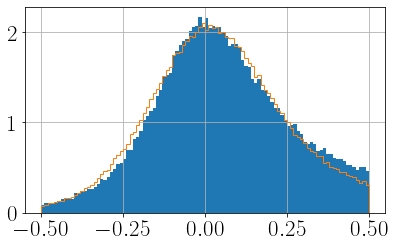

In [1045]:
correctDVCS2(epgExpInbCDFT, 0.01, -0.36, 0).MM2_ep.hist(bins = np.linspace(-0.5, 0.5, 101), density = True)
smearingDVCS(smearingDVCS2(dvcsSimInbCDFT, 0.04, 0.9, 2), 0, 0, 0).MM2_ep.hist(bins = np.linspace(-0.5, 0.5, 101), density = True, histtype = 'step')

<AxesSubplot:>

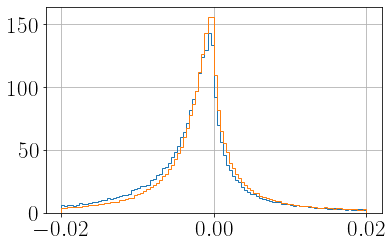

In [1046]:
correctDVCS2(epgExpInbCDFT, 0.01, -0.36, 0).MM2_epg.hist(bins = np.linspace(-0.02, 0.02, 101), density = True, histtype = 'step')
# correctDVCS2(epgExpInbCDFT, 0.0, -0.36, 0).MM2_epg.hist(bins = np.linspace(-0.02, 0.02, 101), density = True, histtype = 'step')
smearingDVCS(smearingDVCS2(dvcsSimInbCDFT, 0.04, 0.9, 2), 0, 0, 0).MM2_epg.hist(bins = np.linspace(-0.02, 0.02, 101), density = True, histtype = 'step')

<AxesSubplot:>

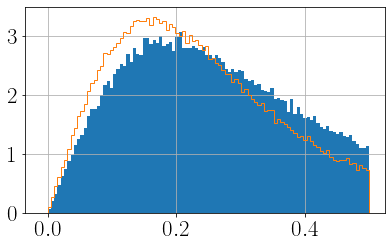

In [1044]:
correctDVCS2(epgExpInbCDFT, 0.01, -0.36, 0).reconGam.hist(bins = np.linspace(-0.01, 0.5, 101), density = True)
# correctDVCS2(epgExpInbCDFT, 0.01, -0.35, 0.1).reconGam.hist(bins = np.linspace(-0.01, 2, 101), density = True, histtype = 'step')
# smearingDVCS2(dvcsSimInbCDFT, 0.04, 0.015, 0.025).reconGam.hist(bins = np.linspace(-0.01, 2, 101), density = True, histtype = 'step')
smearingDVCS(smearingDVCS2(dvcsSimInbCDFT, 0.04, 0.9, 2), 0, 0, 0).reconGam.hist(bins = np.linspace(-0.01, 0.5, 101), density = True, histtype = 'step')

<AxesSubplot:>

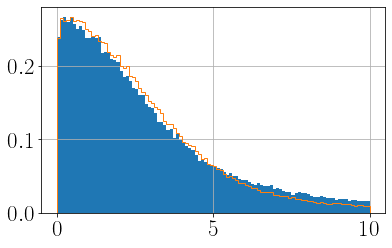

In [1048]:
correctDVCS2(epgExpInbCDFT, 0.01, -0.36, 0).coplanarity.hist(bins = np.linspace(-0.01, 10, 101), density = True)
smearingDVCS(smearingDVCS2(dvcsSimInbCDFT, 0.04, 0.9, 2), 0, 0, 0).coplanarity.hist(bins = np.linspace(-0.01, 10, 101), density = True, histtype = 'step')

<AxesSubplot:>

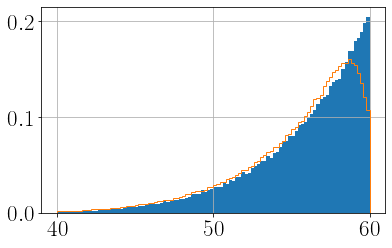

In [1049]:
epgExpInbCDFT.Ptheta.hist(bins = np.linspace(40, 60, 101), density =True)
smearingDVCS(smearingDVCS2(dvcsSimInbCDFT, 0.04, 0.9, 2), 0, 0, 0).Ptheta.hist(bins = np.linspace(40, 60, 101), density = True, histtype = 'step')

<AxesSubplot:>

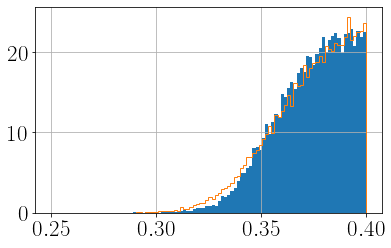

In [1051]:
correctDVCS2(epgExpInbCDFT, 0.01, -0.38, 0).Pp.hist(bins = np.linspace(0.25, 0.4, 101), density =True)
smearingDVCS2(dvcsSimInbCDFT, 0.04, 0.014, 0.025).Pp.hist(bins = np.linspace(0.25, 0.4, 101), density = True, histtype = 'step')

<AxesSubplot:>

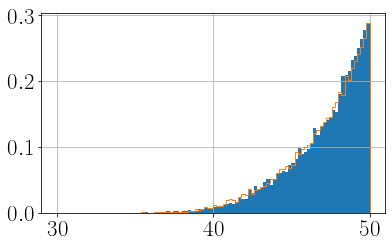

In [1052]:
correctDVCS2(epgExpInbCDFT, 0.012, -0.38, 0).Ptheta.hist(bins = np.linspace(30, 50, 101), density =True)
smearingDVCS2(dvcsSimInbCDFT, 0.04, 0.014, 0.025).Ptheta.hist(bins = np.linspace(30, 50, 101), density = True, histtype = 'step')

<AxesSubplot:>

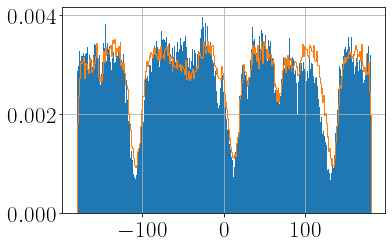

In [1054]:
correctDVCS2(epgExpInbCDFT, 0.01, -0.38, 0).Pphi.hist(bins = np.linspace(-180, 180, 361), density =True)
smearingDVCS2(dvcsSimInbCDFT, 0.04, 0.014, 2).Pphi.hist(bins = np.linspace(-180, 180, 361), density = True, histtype = 'step')

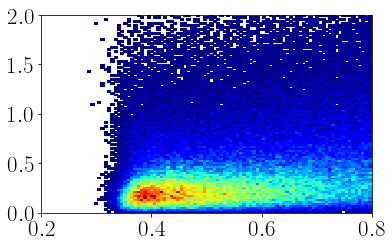

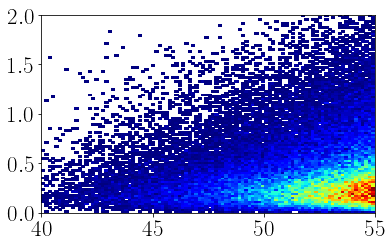

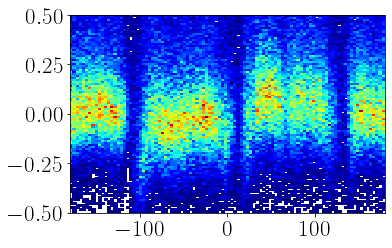

In [998]:
expDat = correctDVCS2(epgExpInbCDFT, 0.01, -0.36, 0)
plt.hist2d(expDat.Pp, expDat.reconGam, bins = [np.linspace(0.2, 0.8, 101), np.linspace(0, 2, 101)], cmap = cmap, cmin = 1)
plt.show()
plt.hist2d(expDat.Ptheta, expDat.reconGam, bins = [np.linspace(40, 55, 101), np.linspace(0, 2, 101)], cmap = cmap, cmin = 1)
plt.show()
plt.hist2d(expDat.Pphi, expDat.MM2_ep, bins = [np.linspace(-180, 180, 101), np.linspace(-0.5, 0.5, 101)], cmap = cmap, cmin = 1)
plt.show()

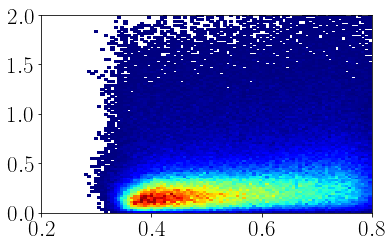

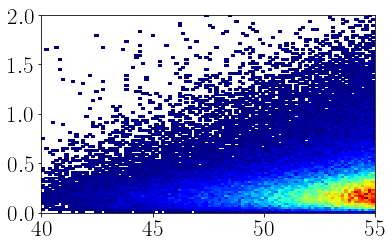

In [733]:
simDat = smearingDVCS2(dvcsSimInbCDFT, 0.04, 0.014, 0.025)
plt.hist2d(simDat.Pp, simDat.reconGam, bins = [np.linspace(0.2, 0.8, 101), np.linspace(0, 2, 101)], cmap = cmap, cmin = 1)
plt.show()
plt.hist2d(simDat.Ptheta, simDat.reconGam, bins = [np.linspace(40, 55, 101), np.linspace(0, 2, 101)], cmap = cmap, cmin = 1)
plt.show()

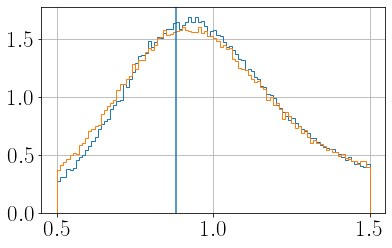

In [960]:
dvcsSimInbCDFT.MM2_eg.hist(bins = np.linspace(0.5, 1.5, 101), density = True, histtype = 'step')
smearingDVCS(dvcsSimInbCDFT_Dec, 0.0, 1, 0).MM2_eg.hist(bins = np.linspace(0.5, 1.5, 101), density = True, histtype = 'step')
plt.axvline(0.938**2)
plt.show()

In [1075]:
epgExpInbCD = copy(exp_1g_corr.loc[(exp_1g_corr.Ee>2)&(exp_1g_corr.Ge>3)&(exp_1g_corr.Pp>0.25)&(exp_1g_corr.Pp<0.8)&((exp_1g_corr.Psector>7)&(exp_1g_corr.Ptheta<60))& (exp_1g_corr.Gsector<7)])
pi0ExpInbCD = copy(exp_2g_corr.loc[(exp_2g_corr.Ee>2)&(exp_2g_corr.Ge>3)&(exp_2g_corr.Pp>0.25)&(exp_2g_corr.Pp<0.8)&((exp_2g_corr.Psector>7)&(exp_2g_corr.Ptheta<60))& (exp_2g_corr.Gsector<7)& (exp_2g_corr.Gsector2<7)])
dvcsSimInbCD = copy(dvcsSimInb.loc[(dvcsSimInb.Ee>2)&(dvcsSimInb.Ge>3)&(dvcsSimInb.Pp>0.25)&(dvcsSimInb.Pp<0.8)&((dvcsSimInb.Psector>7)&(dvcsSimInb.Ptheta<60))& (dvcsSimInb.Gsector<7)])
bkgSimInbCD = copy(bkgSimInb.loc[(bkgSimInb.Ee>2)&(bkgSimInb.Ge>3)&(bkgSimInb.Pp>0.25)&(bkgSimInb.Pp<0.8)&((bkgSimInb.Psector>7)&(bkgSimInb.Ptheta<60))& (bkgSimInb.Gsector<7)])
pi0SimInbCD = copy(pi0SimInb.loc[(pi0SimInb.Ee>2)&(pi0SimInb.Ge>3)&(pi0SimInb.Pp>0.25)&(pi0SimInb.Pp<0.8)&((pi0SimInb.Psector>7)&(pi0SimInb.Ptheta<60))& (pi0SimInb.Gsector<7)])


In [1076]:
epgExpInbCD = correctDVCS2(epgExpInbCD, 0.01, -0.38, 0)
pi0ExpInbCD = correctDVCS2(pi0ExpInbCD, 0.01, -0.38, 0)
dvcsSimInbCD = smearingDVCS2(dvcsSimInbCD, 0.04, 0.9, 2)
bkgSimInbCD = smearingDVCS2(bkgSimInbCD, 0.04, 0.9, 2)
pi0SimInbCD = smearingDVCS2(pi0SimInbCD, 0.04, 0.9, 2)

In [1071]:
contCD = len(pi0ExpInbCD)*len(bkgSimInbCD)/len(pi0SimInbCD)/len(epgExpInbCD)

In [1073]:
print(contCD)

0.16902243432779962


nu 6.018259985924931
xB 0.2327272572797067
W 3.1461178084550303
t2 0.3154679905074614
Q2 2.6476920438177705
phi2 154.87519117414854


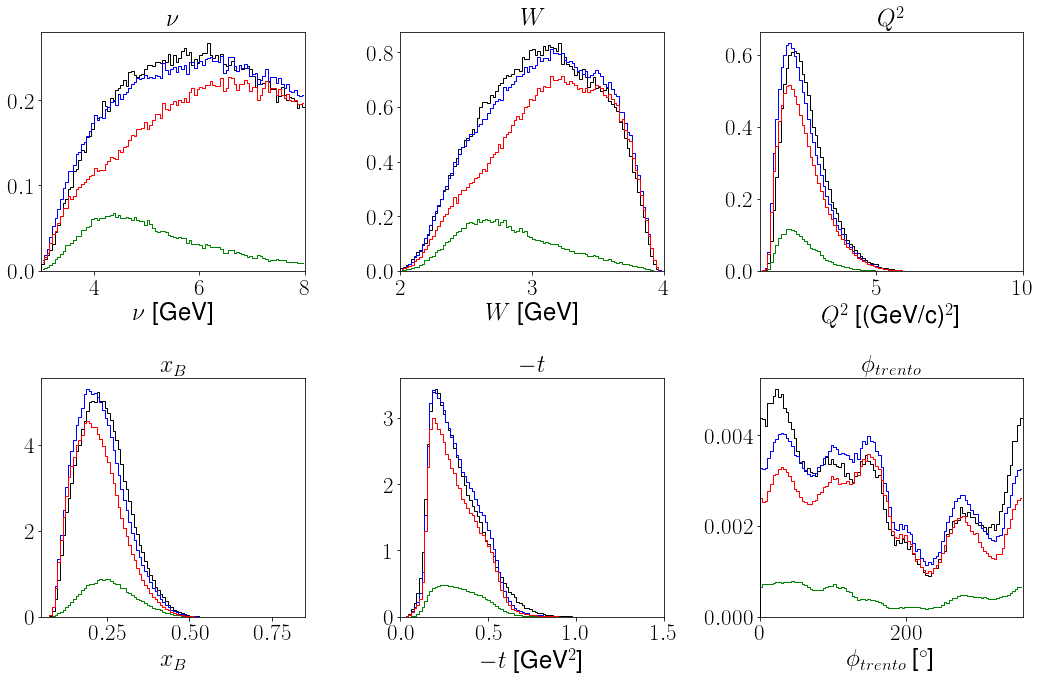

<Figure size 432x288 with 0 Axes>

In [1074]:
varstoplot = ["nu", "W", "Q2", "xB", "t2", "phi2"]
title = [r"$\nu$", r"$W$", r"$Q^{2}$", r"$x_{B}$", r"$-t$", r"$\phi_{trento}$" ]
unit = [GeV, GeV, GeVc2, None, GeV2, degree, GeV2, degree]
binstarts = [3, 2, 1, 0.05, 0, 0]
binends = [8, 4, 10, 0.85, 1.5, 360]
fig, axs = plt.subplots(2, 3, figsize = (15, 10))
for xind in range(0,3):
    for yind in range(0, 2):
        ind =xind+3*yind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
        simDist_dvpi0, bins = np.histogram(bkgSimInbCD[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(dvcsSimInbCD[varstoplot[ind]], bins, density = True)
#         simDist = len_pi0ExpInbCD/len_pi0SimInbCD*simDist_dvpi0 + (len_epgExpInbCD/len_dvcsSimInbCD-len_bkgSimInbCD/len_pi0SimInbCD*len_pi0ExpInbCD/len_dvcsSimInbCD)*simDist_dvcs
        simDist = (1-contCD)*simDist_dvcs + contCD*simDist_dvpi0
        expDist, bins = np.histogram(epgExpInbCD[varstoplot[ind]], bins, density=True)
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
        axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
        axs[yind, xind].step(bincenters, contCD*simDist_dvpi0, where='mid',color='g', linewidth=1)
#         axs[yind, xind].step(bincenters, (1/len_dvcsSimInbCD-cont_inb_FD/len_dvcsSimInbCD)*len_epgExpInbCD*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].hist(epgExpInbCD[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
#         axs[yind, xind].hist(epgExpInbCD[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=1)
#         axs[yind, xind].step(bincenters, expDist - len_pi0ExpInbCD/len_pi0SimInbCD*simDist_dvpi0, where='mid',color='k', linewidth=1)
        print(varstoplot[ind], nphistmean(expDist - len(pi0ExpInbCD)/len(pi0SimInbCD)*simDist_dvpi0, bins))
        axs[yind, xind].step(bincenters, (1-contCD)*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
# axs[0,2].set_xticks([2.2, 2.7, 3.2])
# axs[1,0].set_xticks([0.29, 0.32, 0.35, 0.38])
# axs[1,1].set_xticks([0.23, 0.3, 0.39, 0.52])
# axs[1,2].set_xticks([0, 90, 180, 270, 360])
plt.tight_layout()
# plt.savefig("kineFD.pdf")
# plt.savefig("analysisnote/inbending1.pdf")
plt.show()
correction = 0.005*epgExpInbCD.Gp*2
plt.clf()

coneAngle 23.98962827490463
reconGam 0.5253611043803277
coplanarity 2.6221683517787984
ME_epg 0.12376609043357004
MM2_epg -0.001234557633794713
MM2_eg 0.8951075111322969
MM2_ep 0.014218821603303332
MPt 0.05214140570406548


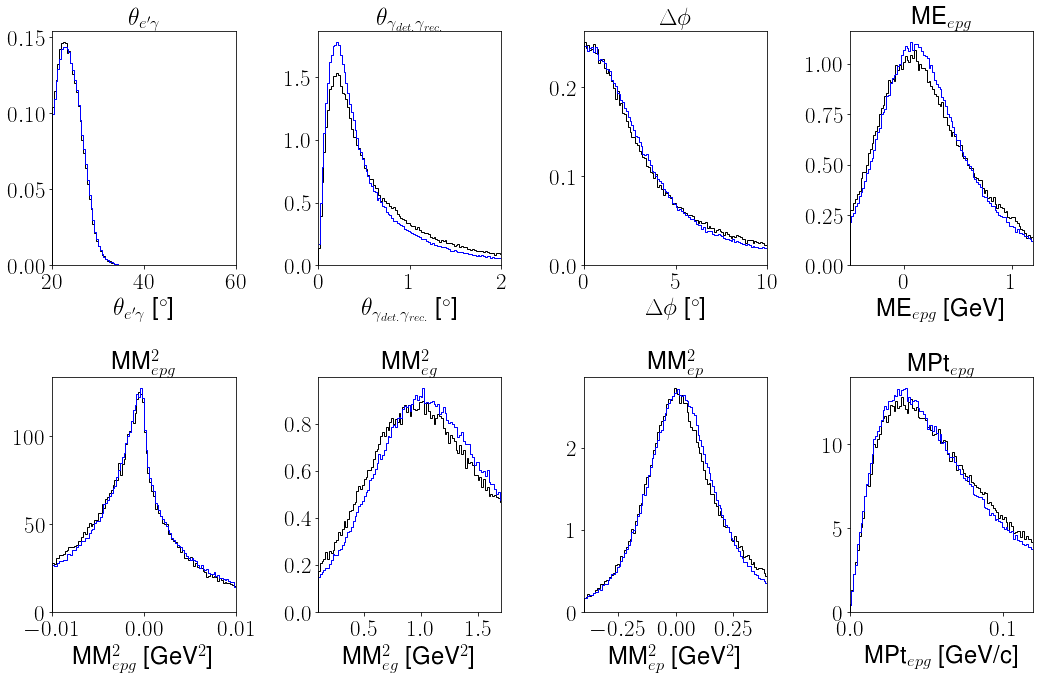

<Figure size 432x288 with 0 Axes>

In [1261]:
correction = 0.0045*epgExpInbCD.Gp**2

varstoplot = ["coneAngle", "reconGam", "coplanarity", "ME_epg", "MM2_epg", "MM2_eg", "MM2_ep", "MPt"]
title = [r"$\theta_{e'\gamma}$", r"$\theta_{\gamma_{det.}\gamma_{rec.}}$", r"$\Delta\phi$" , "ME"+r"${}_{epg}$", "MM"+r"${}^{2}_{epg}$", "MM"+r"${}^{2}_{eg}$", "MM"+r"${}^{2}_{ep}$", "MPt"+r"${}_{epg}$"]
unit = [degree, degree, degree, GeV, GeV2, GeV2, GeV2, GeVc]
binstarts = [20, 0, 0, -0.5, -0.01, 0.1,-0.4 , 0]
binends = [60, 2, 10, 1.2, 0.01, 1.7, 0.4, 0.12]
fig, axs = plt.subplots(2, 4, figsize = (15,10))
for yind in range(0, 2):
    for xind in range(0,4):
        ind = 4*yind + xind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
        simDist_dvpi0, bins = np.histogram(smearingDVCS3(bkgSimInbCD, 0.035)[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(smearingDVCS3(dvcsSimInbCD, 0.035)[varstoplot[ind]], bins, density = True)
#         simDist = len_pi0ExpInbCD/len_pi0SimInbCD*simDist_dvpi0 + (len_epgExpInbCD/len_dvcsSimInbCD-len_bkgSimInbCD/len_pi0SimInbCD*len_pi0ExpInbCD/len_dvcsSimInbCD)*simDist_dvcs
        simDist = (1-contCD)*simDist_dvcs + contCD*simDist_dvpi0
        expDist, bins = np.histogram(correctDVCS3(epgExpInbCD, correction)[varstoplot[ind]], bins, density=True)
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
        axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
#         axs[yind, xind].step(bincenters, c*simDist_dvpi0, where='mid',color='g', linewidth=1)
#         axs[yind, xind].step(bincenters, (1/len_dvcsSimInbCD-cont_inb_CD/len_dvcsSimInbCD)*len_epgExpInbCD*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].hist(correctDVCS3(epgExpInbCD, correction)[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
#         axs[yind, xind].hist(epgExpInbCD[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=1)
#         axs[yind, xind].step(bincenters, expDist - len_pi0ExpInbCD/len_pi0SimInbCD*simDist_dvpi0, where='mid',color='k', linewidth=1)
        print(varstoplot[ind], nphistmean(expDist - len(pi0ExpInbCD)/len(pi0SimInbCD)*simDist_dvpi0, bins))
#         axs[yind, xind].step(bincenters, (1-c)*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
# axs[0,2].set_xticks([2.2, 2.7, 3.2])
# axs[1,0].set_xticks([0.29, 0.32, 0.35, 0.38])
# axs[1,1].set_xticks([0.23, 0.3, 0.39, 0.52])
# axs[1,2].set_xticks([0, 90, 180, 270, 360])
plt.tight_layout()
# plt.savefig("kineCD.pdf")
# plt.savefig("analysisnote/inbending1.pdf")
plt.show()
plt.clf()

Ge 6.106463426988596
Gedep 1.4967801251137354
Gedep1 0.7932594527111537
Gedep2 0.5512483994914873
Gedep3 0.22013423046162356
MM2_eg 0.8796281481685712
ME_epg 0.10601168086743325
MPt 0.05226556656891057


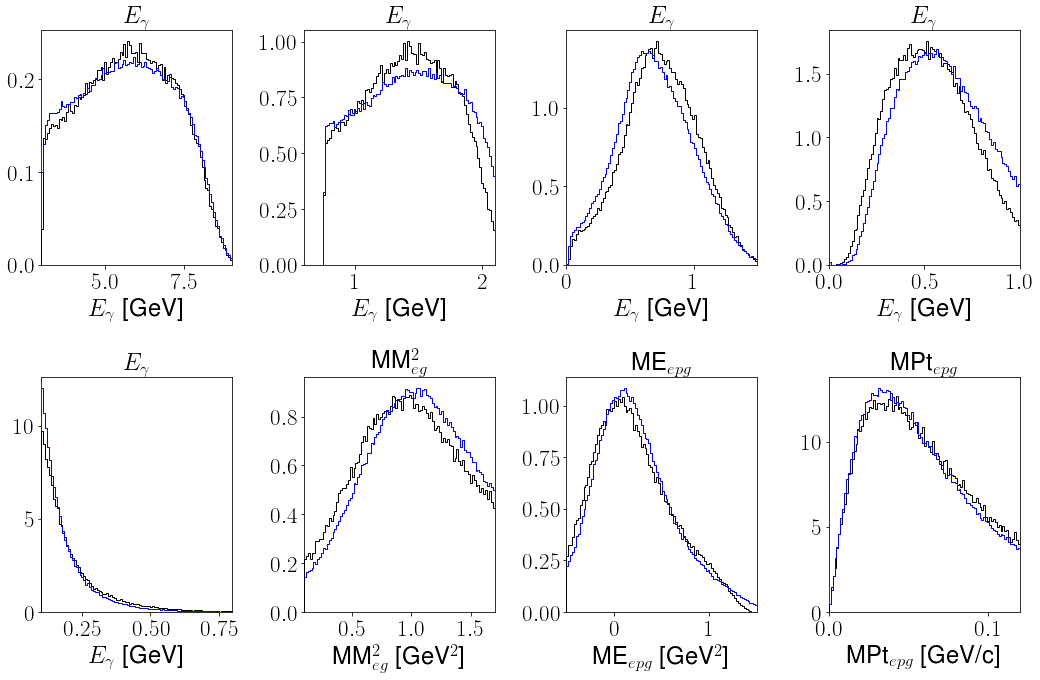

<Figure size 432x288 with 0 Axes>

In [1241]:
correction = 0.004*epgExpInbCD.Gp**2

varstoplot = ["Ge", "Gedep", "Gedep1", "Gedep2", "Gedep3", "MM2_eg", "ME_epg", "MPt"]
title = [r"$E_{\gamma}$", r"$E_{\gamma}$", r"$E_{\gamma}$" , r"$E_{\gamma}$", r"$E_{\gamma}$", "MM"+r"${}^{2}_{eg}$", "ME"+r"${}_{epg}$", "MPt"+r"${}_{epg}$"]
unit = [GeV, GeV, GeV, GeV, GeV, GeV2, GeV2, GeVc]
binstarts = [3, 0.6, 0, 0, 0.1, 0.1, -0.5, 0]
binends = [9, 2.1, 1.5, 1, 0.8, 1.7, 1.5, 0.12]
fig, axs = plt.subplots(2, 4, figsize = (15,10))
for yind in range(0, 2):
    for xind in range(0,4):
        ind = 4*yind + xind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
        simDist_dvpi0, bins = np.histogram(smearingDVCS3(bkgSimInbCD, 0.035)[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(smearingDVCS3(dvcsSimInbCD, 0.035)[varstoplot[ind]], bins, density = True)
#         simDist = len_pi0ExpInbCD/len_pi0SimInbCD*simDist_dvpi0 + (len_epgExpInbCD/len_dvcsSimInbCD-len_bkgSimInbCD/len_pi0SimInbCD*len_pi0ExpInbCD/len_dvcsSimInbCD)*simDist_dvcs
        simDist = (1-contCD)*simDist_dvcs + contCD*simDist_dvpi0
        expDist, bins = np.histogram(correctDVCS3(epgExpInbCD, correction)[varstoplot[ind]], bins, density=True)
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
        axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
#         axs[yind, xind].step(bincenters, c*simDist_dvpi0, where='mid',color='g', linewidth=1)
#         axs[yind, xind].step(bincenters, (1/len_dvcsSimInbCD-cont_inb_CD/len_dvcsSimInbCD)*len_epgExpInbCD*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].hist(correctDVCS3(epgExpInbCD, correction)[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
#         axs[yind, xind].hist(epgExpInbCD[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=1)
#         axs[yind, xind].step(bincenters, expDist - len_pi0ExpInbCD/len_pi0SimInbCD*simDist_dvpi0, where='mid',color='k', linewidth=1)
        print(varstoplot[ind], nphistmean(expDist - len(pi0ExpInbCD)/len(pi0SimInbCD)*simDist_dvpi0, bins))
#         axs[yind, xind].step(bincenters, (1-c)*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
# axs[0,2].set_xticks([2.2, 2.7, 3.2])
# axs[1,0].set_xticks([0.29, 0.32, 0.35, 0.38])
# axs[1,1].set_xticks([0.23, 0.3, 0.39, 0.52])
# axs[1,2].set_xticks([0, 90, 180, 270, 360])
plt.tight_layout()
# plt.savefig("kineCD.pdf")
# plt.savefig("analysisnote/inbending1.pdf")
plt.show()
plt.clf()

In [1168]:
def correctDVCS3(df_epg, correction=0):
    #set up dvcs variables
    df_epg = copy(df_epg)

    ele = [df_epg['Epx'], df_epg['Epy'], df_epg['Epz']]
#     df_epg.loc[:, 'Ep'] = mag(ele)
#     df_epg.loc[:, 'Ee'] = getEnergy(ele, me)
#     df_epg.loc[:, 'Etheta'] = getTheta(ele)
#     df_epg.loc[:, 'Ephi'] = getPhi(ele)

    pro = [df_epg['Ppx'], df_epg['Ppy'], df_epg['Ppz']]
#     df_epg.loc[:, 'Pp'] = mag(pro)
#     df_epg.loc[:, 'Pe'] = getEnergy(pro, 0)
#     df_epg.loc[:, 'Ptheta'] = getTheta(pro)
#     df_epg.loc[:, 'Pphi'] = getPhi(pro)

    df_epg.loc[df_epg.Gsector<7, 'Gp'] = df_epg.loc[df_epg.Gsector<7, 'Gp'] + correction
    df_epg.loc[df_epg.Gsector<7, 'Ge'] = df_epg.loc[df_epg.Gsector<7, 'Gp']
#     df_epg.loc[:, 'Gtheta'] = getTheta(gam)
#     df_epg.loc[:, 'Gphi'] = getPhi(gam)
    df_epg.loc[:, "Gpx"] = df_epg.loc[:, "Gp"]*np.sin(np.radians(df_epg.loc[:, "Gtheta"]))*np.cos(np.radians(df_epg.loc[:, "Gphi"]))
    df_epg.loc[:, "Gpy"] = df_epg.loc[:, "Gp"]*np.sin(np.radians(df_epg.loc[:, "Gtheta"]))*np.sin(np.radians(df_epg.loc[:, "Gphi"]))
    df_epg.loc[:, "Gpz"] = df_epg.loc[:, "Gp"]*np.cos(np.radians(df_epg.loc[:, "Gtheta"]))
    gam = [df_epg['Gpx'], df_epg['Gpy'], df_epg['Gpz']]

    Ppt = mag([df_epg['Ppx'], df_epg['Ppy'], 0])

    VGS = [-df_epg['Epx'], -df_epg['Epy'], pbeam - df_epg['Epz']]
    v3l = cross(beam, ele)
    v3h = cross(pro, VGS)
    v3g = cross(VGS, gam)
    VmissG = [-df_epg["Epx"] - df_epg["Ppx"], -df_epg["Epy"] - df_epg["Ppy"],
              pbeam - df_epg["Epz"] - df_epg["Ppz"]]
    VmissP = [-(df_epg["Epx"] + df_epg["Gpx"]), -(df_epg["Epy"] + df_epg["Gpy"]),
              -(-pbeam + df_epg["Epz"] + df_epg["Gpz"])]
    Vmiss = [-(df_epg["Epx"] + df_epg["Ppx"] + df_epg["Gpx"]), -(df_epg["Epy"] + df_epg["Ppy"] + df_epg["Gpy"]),
             -(-pbeam + df_epg["Epz"] + df_epg["Ppz"] + df_epg["Gpz"])]
    costheta = cosTheta(VGS, gam)

    df_epg.loc[:, 'Mpx'], df_epg.loc[:, 'Mpy'], df_epg.loc[:, 'Mpz'] = Vmiss

    # binning kinematics
    df_epg.loc[:,'Q2'] = -((ebeam - df_epg['Ee'])**2 - mag2(VGS))
    df_epg.loc[:,'nu'] = (ebeam - df_epg['Ee'])
    df_epg.loc[:,'y'] = df_epg['nu']/ebeam
    df_epg.loc[:,'xB'] = df_epg['Q2'] / 2.0 / M / df_epg['nu']
    df_epg.loc[:,'t1'] = 2 * M * (df_epg['Pe'] - M)
    df_epg.loc[:,'t2'] = (M * df_epg['Q2'] + 2 * M * df_epg['nu'] * (df_epg['nu'] - np.sqrt(df_epg['nu'] * df_epg['nu'] + df_epg['Q2']) * costheta))\
    / (M + df_epg['nu'] - np.sqrt(df_epg['nu'] * df_epg['nu'] + df_epg['Q2']) * costheta)
    df_epg.loc[:,'W'] = np.sqrt(np.maximum(0, (ebeam + M - df_epg['Ee'])**2 - mag2(VGS)))

    # trento angles
    df_epg.loc[:,'phi1'] = angle(v3l, v3h)
    df_epg.loc[:,'phi1'] = np.where(dot(v3l, pro) > 0, 360.0 -
                              df_epg['phi1'], df_epg['phi1'])
    df_epg.loc[:,'phi2'] = angle(v3l, v3g)
    df_epg.loc[:,'phi2'] = np.where(dot(v3l, gam) <
                              0, 360.0 - df_epg['phi2'], df_epg['phi2'])

    # exclusivity variables
    df_epg.loc[:,'MM2_epg'] = (-M - ebeam + df_epg["Ee"] +
                         df_epg["Pe"] + df_epg["Ge"])**2 - mag2(Vmiss)
    df_epg.loc[:,'ME_epg'] = (M + ebeam - df_epg["Ee"] - df_epg["Pe"] - df_epg["Ge"])
    df_epg.loc[:,'MM2_ep'] = (-M - ebeam + df_epg["Ee"] + df_epg["Pe"])**2 - mag2(VmissG)
    df_epg.loc[:,'MM2_eg'] = (-M - ebeam + df_epg["Ee"] + df_epg["Ge"])**2 - mag2(VmissP)
    df_epg.loc[:,'MPt'] = np.sqrt((df_epg["Epx"] + df_epg["Ppx"] + df_epg["Gpx"])**2 +
                            (df_epg["Epy"] + df_epg["Ppy"] + df_epg["Gpy"])**2)
    df_epg.loc[:,'coneAngle'] = angle(ele, gam)
    df_epg.loc[:,'reconGam'] = angle(gam, VmissG)
    df_epg.loc[:,'coplanarity'] = angle(v3h, v3g)
    
    return df_epg


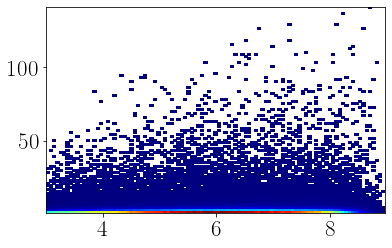

In [1139]:
plt.hist2d(dvcsSimInbCD.Gp, dvcsSimInbCD.Gedep/dvcsSimInbCD.Gedep1, bins = 101, cmap = cmap, cmin = 1)
plt.show()

In [1123]:
dvcsSimInbCD.loc[:, "GenGp"] = np.where(np.isnan(dvcsSimInbCD["GenGpz"]), dvcsSimInbCD.loc[:, "GenGp2"], dvcsSimInbCD.loc[:, "GenGp"])
dvcsSimInbCD.loc[:, "GenGpx"] = np.where(np.isnan(dvcsSimInbCD["GenGpz"]), dvcsSimInbCD.loc[:, "GenGpx2"], dvcsSimInbCD.loc[:, "GenGpx"])
dvcsSimInbCD.loc[:, "GenGpy"] = np.where(np.isnan(dvcsSimInbCD["GenGpz"]), dvcsSimInbCD.loc[:, "GenGpy2"], dvcsSimInbCD.loc[:, "GenGpy"])
dvcsSimInbCD.loc[:, "GenGpz"] = np.where(np.isnan(dvcsSimInbCD["GenGpz"]), dvcsSimInbCD.loc[:, "GenGpz2"], dvcsSimInbCD.loc[:, "GenGpz"])

<AxesSubplot:>

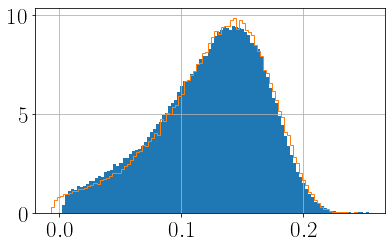

In [1153]:
(dvcsSimInbCD.Gedep1/dvcsSimInbCD.Gp).hist(bins = 101, density = True)
(epgExpInbCD.Gedep1/epgExpInbCD.Gp-0.01).hist(bins = 101, density = True, histtype = 'step')
# plt.axvline(0.14)

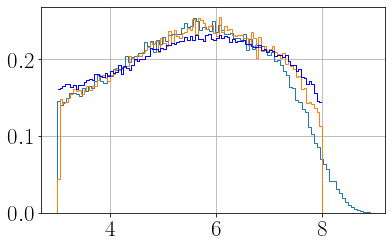

In [1236]:
bins = np.linspace(3, 8, 101)
bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])

(epgExpInbCD.Gp).hist(bins = 101, density = True, histtype = 'step')
(correctDVCS3(epgExpInbCD, 0.004*epgExpInbCD.Gp**2).Gp).hist(bins = bins, density = True, histtype = 'step')
simDist_dvpi0, bins = np.histogram(bkgSimInbCD.Gp, bins, density = True)
simDist_dvcs, bins = np.histogram(dvcsSimInbCD.Gp, bins, density = True)
simDist = (1-contCD)*simDist_dvcs + contCD*simDist_dvpi0
plt.step(bincenters, simDist, where='mid',color='b', linewidth=1)


In [1195]:
def smearingDVCS3(df_epg, sigma = 0):
    #set up dvcs variables
    df_epg = copy(df_epg)

    ele = [df_epg['Epx'], df_epg['Epy'], df_epg['Epz']]
#     df_epg.loc[:, 'Ep'] = mag(ele)
#     df_epg.loc[:, 'Ee'] = getEnergy(ele, me)
#     df_epg.loc[:, 'Etheta'] = getTheta(ele)
#     df_epg.loc[:, 'Ephi'] = getPhi(ele)

    pro = [df_epg['Ppx'], df_epg['Ppy'], df_epg['Ppz']]
#     df_epg.loc[:, 'Pp'] = mag(pro)
#     df_epg.loc[:, 'Pe'] = getEnergy(pro, 0)
#     df_epg.loc[:, 'Ptheta'] = getTheta(pro)
#     df_epg.loc[:, 'Pphi'] = getPhi(pro)

    df_epg.loc[df_epg.Gsector<7, 'Gp'] = np.random.normal(1, sigma, len(df_epg.loc[df_epg.Gsector<7]))*df_epg.loc[df_epg.Gsector<7, 'Gp']
    df_epg.loc[df_epg.Gsector<7, 'Ge'] = df_epg.loc[df_epg.Gsector<7, 'Gp']
#     df_epg.loc[:, 'Gtheta'] = getTheta(gam)
#     df_epg.loc[:, 'Gphi'] = getPhi(gam)
    df_epg.loc[:, "Gpx"] = df_epg.loc[:, "Gp"]*np.sin(np.radians(df_epg.loc[:, "Gtheta"]))*np.cos(np.radians(df_epg.loc[:, "Gphi"]))
    df_epg.loc[:, "Gpy"] = df_epg.loc[:, "Gp"]*np.sin(np.radians(df_epg.loc[:, "Gtheta"]))*np.sin(np.radians(df_epg.loc[:, "Gphi"]))
    df_epg.loc[:, "Gpz"] = df_epg.loc[:, "Gp"]*np.cos(np.radians(df_epg.loc[:, "Gtheta"]))
    gam = [df_epg['Gpx'], df_epg['Gpy'], df_epg['Gpz']]
    
    Ppt = mag([df_epg['Ppx'], df_epg['Ppy'], 0])

    VGS = [-df_epg['Epx'], -df_epg['Epy'], pbeam - df_epg['Epz']]
    v3l = cross(beam, ele)
    v3h = cross(pro, VGS)
    v3g = cross(VGS, gam)
    VmissG = [-df_epg["Epx"] - df_epg["Ppx"], -df_epg["Epy"] - df_epg["Ppy"],
              pbeam - df_epg["Epz"] - df_epg["Ppz"]]
    VmissP = [-(df_epg["Epx"] + df_epg["Gpx"]), -(df_epg["Epy"] + df_epg["Gpy"]),
              -(-pbeam + df_epg["Epz"] + df_epg["Gpz"])]
    Vmiss = [-(df_epg["Epx"] + df_epg["Ppx"] + df_epg["Gpx"]), -(df_epg["Epy"] + df_epg["Ppy"] + df_epg["Gpy"]),
             -(-pbeam + df_epg["Epz"] + df_epg["Ppz"] + df_epg["Gpz"])]
    costheta = cosTheta(VGS, gam)

    df_epg.loc[:, 'Mpx'], df_epg.loc[:, 'Mpy'], df_epg.loc[:, 'Mpz'] = Vmiss

    # binning kinematics
    df_epg.loc[:,'Q2'] = -((ebeam - df_epg['Ee'])**2 - mag2(VGS))
    df_epg.loc[:,'nu'] = (ebeam - df_epg['Ee'])
    df_epg.loc[:,'y'] = df_epg['nu']/ebeam
    df_epg.loc[:,'xB'] = df_epg['Q2'] / 2.0 / M / df_epg['nu']
    df_epg.loc[:,'t1'] = 2 * M * (df_epg['Pe'] - M)
    df_epg.loc[:,'t2'] = (M * df_epg['Q2'] + 2 * M * df_epg['nu'] * (df_epg['nu'] - np.sqrt(df_epg['nu'] * df_epg['nu'] + df_epg['Q2']) * costheta))\
    / (M + df_epg['nu'] - np.sqrt(df_epg['nu'] * df_epg['nu'] + df_epg['Q2']) * costheta)
    df_epg.loc[:,'W'] = np.sqrt(np.maximum(0, (ebeam + M - df_epg['Ee'])**2 - mag2(VGS)))

    # trento angles
    df_epg.loc[:,'phi1'] = angle(v3l, v3h)
    df_epg.loc[:,'phi1'] = np.where(dot(v3l, pro) > 0, 360.0 -
                              df_epg['phi1'], df_epg['phi1'])
    df_epg.loc[:,'phi2'] = angle(v3l, v3g)
    df_epg.loc[:,'phi2'] = np.where(dot(v3l, gam) <
                              0, 360.0 - df_epg['phi2'], df_epg['phi2'])

    # exclusivity variables
    df_epg.loc[:,'MM2_epg'] = (-M - ebeam + df_epg["Ee"] +
                         df_epg["Pe"] + df_epg["Ge"])**2 - mag2(Vmiss)
    df_epg.loc[:,'ME_epg'] = (M + ebeam - df_epg["Ee"] - df_epg["Pe"] - df_epg["Ge"])
    df_epg.loc[:,'MM2_ep'] = (-M - ebeam + df_epg["Ee"] + df_epg["Pe"])**2 - mag2(VmissG)
    df_epg.loc[:,'MM2_eg'] = (-M - ebeam + df_epg["Ee"] + df_epg["Ge"])**2 - mag2(VmissP)
    df_epg.loc[:,'MPt'] = np.sqrt((df_epg["Epx"] + df_epg["Ppx"] + df_epg["Gpx"])**2 +
                            (df_epg["Epy"] + df_epg["Ppy"] + df_epg["Gpy"])**2)
    df_epg.loc[:,'coneAngle'] = angle(ele, gam)
    df_epg.loc[:,'reconGam'] = angle(gam, VmissG)
    df_epg.loc[:,'coplanarity'] = angle(v3h, v3g)
    
    return df_epg


In [1251]:
epgExpInbFD = copy(exp_1g_corr.loc[(exp_1g_corr.Ee>2)&(exp_1g_corr.Ge>3)&(exp_1g_corr.Pp>0.35)&(exp_1g_corr.Pp<0.8)&((exp_1g_corr.Psector<7)&(exp_1g_corr.Ptheta<32))& (exp_1g_corr.Gsector<7)])
pi0ExpInbFD = copy(exp_2g_corr.loc[(exp_2g_corr.Ee>2)&(exp_2g_corr.Ge>3)&(exp_2g_corr.Pp>0.35)&(exp_2g_corr.Pp<0.8)&((exp_2g_corr.Psector<7)&(exp_2g_corr.Ptheta<32))& (exp_2g_corr.Gsector<7)& (exp_2g_corr.Gsector2<7)])
dvcsSimInbFD = copy(dvcsSimInb.loc[(dvcsSimInb.Ee>2)&(dvcsSimInb.Ge>3)&(dvcsSimInb.Pp>0.35)&(dvcsSimInb.Pp<0.8)&((dvcsSimInb.Psector<7)&(dvcsSimInb.Ptheta<32))& (dvcsSimInb.Gsector<7)])
bkgSimInbFD = copy(bkgSimInb.loc[(bkgSimInb.Ee>2)&(bkgSimInb.Ge>3)&(bkgSimInb.Pp>0.35)&(bkgSimInb.Pp<0.8)&((bkgSimInb.Psector<7)&(bkgSimInb.Ptheta<32))& (bkgSimInb.Gsector<7)])
pi0SimInbFD = copy(pi0SimInb.loc[(pi0SimInb.Ee>2)&(pi0SimInb.Ge>3)&(pi0SimInb.Pp>0.35)&(pi0SimInb.Pp<0.8)&((pi0SimInb.Psector<7)&(pi0SimInb.Ptheta<32))& (pi0SimInb.Gsector<7)])


In [1252]:
# epgExpInbFD = correctDVCS3(epgExpInbFD, 0.004*epgExpInbFD.Gp**2)
# pi0ExpInbFD = correctDVCS3(pi0ExpInbFD, 0.004*pi0ExpInbFD.Gp**2)
dvcsSimInbFD = smearingDVCS3(dvcsSimInbFD, 0.035)
bkgSimInbFD = smearingDVCS3(bkgSimInbFD, 0.035)
pi0SimInbFD = smearingDVCS3(pi0SimInbFD, 0.035)

In [1249]:
contFD = len(pi0ExpInbFD)*len(bkgSimInbFD)/len(pi0SimInbFD)/len(epgExpInbFD)

coneAngle 32.3542449281531 0.025
reconGam 0.6608661076028921 0.5
coplanarity 3.791171868773224 0.1
ME_epg 0.15448558449414465 0.5882352941176471
MM2_epg -0.0010202326729802226 50.0
MM2_eg 0.9656720082671624 0.6249999999999999
MM2_ep 0.011526383991413765 1.2499999999999998
MPt 0.057979865622010164 8.333333333333332


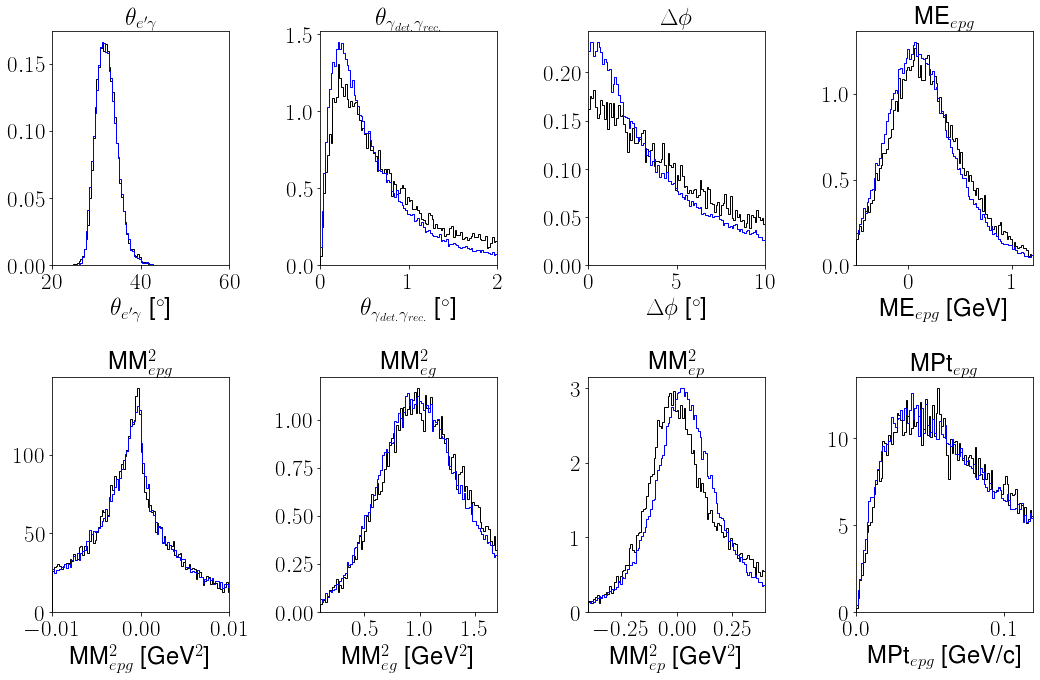

<Figure size 432x288 with 0 Axes>

In [1336]:
correction = 0.0045*epgExpInbFD.Gp**2

varstoplot = ["coneAngle", "reconGam", "coplanarity", "ME_epg", "MM2_epg", "MM2_eg", "MM2_ep", "MPt"]
title = [r"$\theta_{e'\gamma}$", r"$\theta_{\gamma_{det.}\gamma_{rec.}}$", r"$\Delta\phi$" , "ME"+r"${}_{epg}$", "MM"+r"${}^{2}_{epg}$", "MM"+r"${}^{2}_{eg}$", "MM"+r"${}^{2}_{ep}$", "MPt"+r"${}_{epg}$"]
unit = [degree, degree, degree, GeV, GeV2, GeV2, GeV2, GeVc]
binstarts = [20, 0, 0, -0.5, -0.01, 0.1,-0.4 , 0]
binends = [60, 2, 10, 1.2, 0.01, 1.7, 0.4, 0.12]
fig, axs = plt.subplots(2, 4, figsize = (15,10))
for yind in range(0, 2):
    for xind in range(0,4):
        ind = 4*yind + xind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
        simDist_dvpi0, bins = np.histogram(smearingDVCS4(bkgSimInbFD, 0.06, 0, 0)[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(smearingDVCS4(dvcsSimInbFD, 0.06, 0, 0)[varstoplot[ind]], bins, density = True)
#         simDist = len_pi0ExpInbFD/len_pi0SimInbFD*simDist_dvpi0 + (len_epgExpInbFD/len_dvcsSimInbFD-len_bkgSimInbFD/len_pi0SimInbFD*len_pi0ExpInbFD/len_dvcsSimInbFD)*simDist_dvcs
        simDist = (1-contFD)*simDist_dvcs + contFD*simDist_dvpi0
        expDist, bins = np.histogram(correctDVCS4(correctDVCS3(epgExpInbFD, correction), 0, 0, 0)[varstoplot[ind]], bins, density=True)
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
        axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
#         axs[yind, xind].step(bincenters, c*simDist_dvpi0, where='mid',color='g', linewidth=1)
#         axs[yind, xind].step(bincenters, (1/len_dvcsSimInbFD-cont_inb_FD/len_dvcsSimInbFD)*len_epgExpInbFD*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].hist(correctDVCS4(correctDVCS3(epgExpInbFD, correction), 0, 0, 0)[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
#         axs[yind, xind].hist(epgExpInbFD[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=1)
#         axs[yind, xind].step(bincenters, expDist - len_pi0ExpInbFD/len_pi0SimInbFD*simDist_dvpi0, where='mid',color='k', linewidth=1)
        print(varstoplot[ind], nphistmean(expDist - len(pi0ExpInbFD)/len(pi0SimInbFD)*simDist_dvpi0, bins), simDist.mean())
#         axs[yind, xind].step(bincenters, (1-c)*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
# axs[0,2].set_xticks([2.2, 2.7, 3.2])
# axs[1,0].set_xticks([0.29, 0.32, 0.35, 0.38])
# axs[1,1].set_xticks([0.23, 0.3, 0.39, 0.52])
# axs[1,2].set_xticks([0, 90, 180, 270, 360])
plt.tight_layout()
# plt.savefig("kineFD.pdf")
# plt.savefig("analysisnote/inbending1.pdf")
plt.show()
plt.clf()

In [1309]:
def smearingDVCS4(df_epg, sigma = 0, sigma2 = 0, sigma3 = 0):
    #set up dvcs variables
    df_epg = copy(df_epg)

    ele = [df_epg['Epx'], df_epg['Epy'], df_epg['Epz']]
#     df_epg.loc[:, 'Ep'] = mag(ele)
#     df_epg.loc[:, 'Ee'] = getEnergy(ele, me)
#     df_epg.loc[:, 'Etheta'] = getTheta(ele)
#     df_epg.loc[:, 'Ephi'] = getPhi(ele)

    df_epg.loc[df_epg.Psector<7, 'Pp'] = np.random.normal(1, sigma, len(df_epg.loc[df_epg.Psector<7]))*df_epg.loc[df_epg.Psector<7, 'Pp']
    df_epg.loc[df_epg.Psector<7, 'Pe'] = np.sqrt(df_epg.loc[df_epg.Psector<7, 'Pp']**2+M**2)
    df_epg.loc[df_epg.Psector<7, 'Ptheta'] = np.random.normal(0, sigma2, len(df_epg.loc[df_epg.Psector<7]))+df_epg.loc[df_epg.Psector<7, 'Ptheta']
    df_epg.loc[df_epg.Psector>7, 'Pphi'] = np.random.normal(0, sigma3, len(df_epg.loc[df_epg.Psector<7]))+df_epg.loc[df_epg.Psector<7, 'Pphi']
    df_epg.loc[:, "Ppx"] = df_epg.loc[:, "Pp"]*np.sin(np.radians(df_epg.loc[:, "Ptheta"]))*np.cos(np.radians(df_epg.loc[:, "Pphi"]))
    df_epg.loc[:, "Ppy"] = df_epg.loc[:, "Pp"]*np.sin(np.radians(df_epg.loc[:, "Ptheta"]))*np.sin(np.radians(df_epg.loc[:, "Pphi"]))
    df_epg.loc[:, "Ppz"] = df_epg.loc[:, "Pp"]*np.cos(np.radians(df_epg.loc[:, "Ptheta"]))
    pro = [df_epg['Ppx'], df_epg['Ppy'], df_epg['Ppz']]

#     df_epg.loc[:, 'Gp'] = np.random.normal(1, sigma, len(df_epg))*df_epg.loc[:, 'Gp']
#     df_epg.loc[:, 'Ge'] = df_epg.loc[:, 'Gp']
# #     df_epg.loc[:, 'Gtheta'] = getTheta(gam)
# #     df_epg.loc[:, 'Gphi'] = getPhi(gam)
#     df_epg.loc[:, "Gpx"] = df_epg.loc[:, "Gp"]*np.sin(np.radians(df_epg.loc[:, "Gtheta"]))*np.cos(np.radians(df_epg.loc[:, "Gphi"]))
#     df_epg.loc[:, "Gpy"] = df_epg.loc[:, "Gp"]*np.sin(np.radians(df_epg.loc[:, "Gtheta"]))*np.sin(np.radians(df_epg.loc[:, "Gphi"]))
#     df_epg.loc[:, "Gpz"] = df_epg.loc[:, "Gp"]*np.cos(np.radians(df_epg.loc[:, "Gtheta"]))
    gam = [df_epg['Gpx'], df_epg['Gpy'], df_epg['Gpz']]
    
    Ppt = mag([df_epg['Ppx'], df_epg['Ppy'], 0])

    VGS = [-df_epg['Epx'], -df_epg['Epy'], pbeam - df_epg['Epz']]
    v3l = cross(beam, ele)
    v3h = cross(pro, VGS)
    v3g = cross(VGS, gam)
    VmissG = [-df_epg["Epx"] - df_epg["Ppx"], -df_epg["Epy"] - df_epg["Ppy"],
              pbeam - df_epg["Epz"] - df_epg["Ppz"]]
    VmissP = [-(df_epg["Epx"] + df_epg["Gpx"]), -(df_epg["Epy"] + df_epg["Gpy"]),
              -(-pbeam + df_epg["Epz"] + df_epg["Gpz"])]
    Vmiss = [-(df_epg["Epx"] + df_epg["Ppx"] + df_epg["Gpx"]), -(df_epg["Epy"] + df_epg["Ppy"] + df_epg["Gpy"]),
             -(-pbeam + df_epg["Epz"] + df_epg["Ppz"] + df_epg["Gpz"])]
    costheta = cosTheta(VGS, gam)

    df_epg.loc[:, 'Mpx'], df_epg.loc[:, 'Mpy'], df_epg.loc[:, 'Mpz'] = Vmiss

    # binning kinematics
    df_epg.loc[:,'Q2'] = -((ebeam - df_epg['Ee'])**2 - mag2(VGS))
    df_epg.loc[:,'nu'] = (ebeam - df_epg['Ee'])
    df_epg.loc[:,'y'] = df_epg['nu']/ebeam
    df_epg.loc[:,'xB'] = df_epg['Q2'] / 2.0 / M / df_epg['nu']
    df_epg.loc[:,'t1'] = 2 * M * (df_epg['Pe'] - M)
    df_epg.loc[:,'t2'] = (M * df_epg['Q2'] + 2 * M * df_epg['nu'] * (df_epg['nu'] - np.sqrt(df_epg['nu'] * df_epg['nu'] + df_epg['Q2']) * costheta))\
    / (M + df_epg['nu'] - np.sqrt(df_epg['nu'] * df_epg['nu'] + df_epg['Q2']) * costheta)
    df_epg.loc[:,'W'] = np.sqrt(np.maximum(0, (ebeam + M - df_epg['Ee'])**2 - mag2(VGS)))

    # trento angles
    df_epg.loc[:,'phi1'] = angle(v3l, v3h)
    df_epg.loc[:,'phi1'] = np.where(dot(v3l, pro) > 0, 360.0 -
                              df_epg['phi1'], df_epg['phi1'])
    df_epg.loc[:,'phi2'] = angle(v3l, v3g)
    df_epg.loc[:,'phi2'] = np.where(dot(v3l, gam) <
                              0, 360.0 - df_epg['phi2'], df_epg['phi2'])

    # exclusivity variables
    df_epg.loc[:,'MM2_epg'] = (-M - ebeam + df_epg["Ee"] +
                         df_epg["Pe"] + df_epg["Ge"])**2 - mag2(Vmiss)
    df_epg.loc[:,'ME_epg'] = (M + ebeam - df_epg["Ee"] - df_epg["Pe"] - df_epg["Ge"])
    df_epg.loc[:,'MM2_ep'] = (-M - ebeam + df_epg["Ee"] + df_epg["Pe"])**2 - mag2(VmissG)
    df_epg.loc[:,'MM2_eg'] = (-M - ebeam + df_epg["Ee"] + df_epg["Ge"])**2 - mag2(VmissP)
    df_epg.loc[:,'MPt'] = np.sqrt((df_epg["Epx"] + df_epg["Ppx"] + df_epg["Gpx"])**2 +
                            (df_epg["Epy"] + df_epg["Ppy"] + df_epg["Gpy"])**2)
    df_epg.loc[:,'coneAngle'] = angle(ele, gam)
    df_epg.loc[:,'reconGam'] = angle(gam, VmissG)
    df_epg.loc[:,'coplanarity'] = angle(v3h, v3g)
    
    return df_epg


Gp 5.525051095302988 0.18181818181818177
Pp 0.6110767774937957 2.8571428571428568
Gtheta 15.771120079866803 0.024999999999999994
Gphi -1.461393953926114 0.002777777777777778
Ptheta 24.44072868356876 0.025
Pphi -2.1361795721122534 0.0027777777777777775
MM2_ep 0.013357741106717419 1.2499999999999998
coplanarity 3.7571153171955722 0.09999999999999998


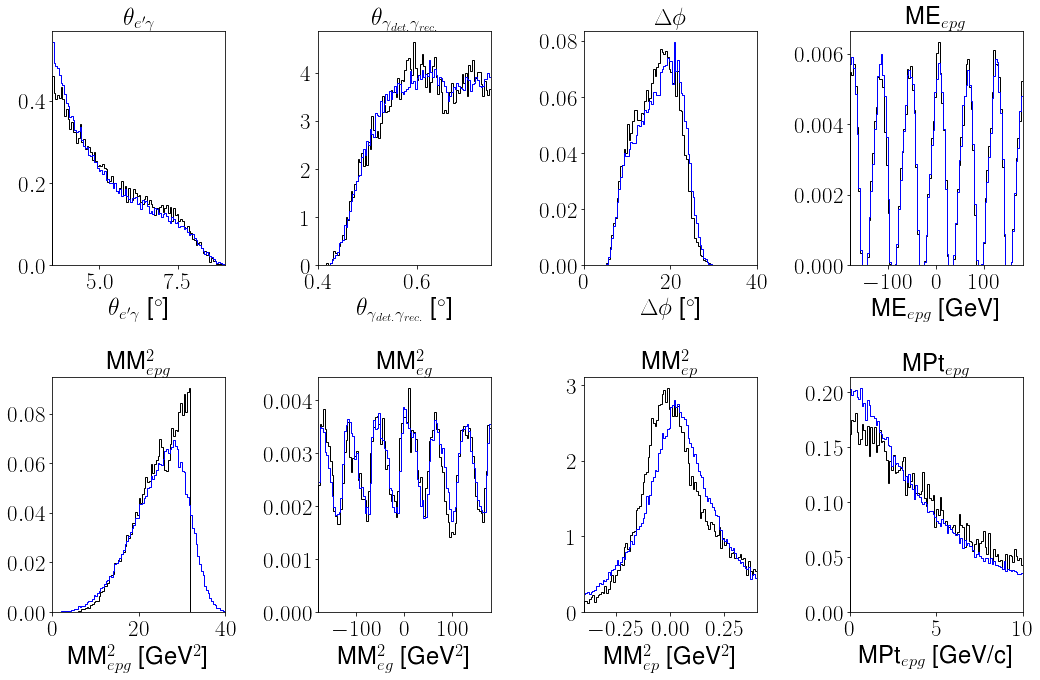

<Figure size 432x288 with 0 Axes>

In [1333]:
varstoplot = ["Gp", "Pp", "Gtheta", "Gphi", "Ptheta", "Pphi", "MM2_ep", "coplanarity"]
title = [r"$\theta_{e'\gamma}$", r"$\theta_{\gamma_{det.}\gamma_{rec.}}$", r"$\Delta\phi$" , "ME"+r"${}_{epg}$", "MM"+r"${}^{2}_{epg}$", "MM"+r"${}^{2}_{eg}$", "MM"+r"${}^{2}_{ep}$", "MPt"+r"${}_{epg}$"]
unit = [degree, degree, degree, GeV, GeV2, GeV2, GeV2, GeVc]
binstarts = [3.5, 0.4, 0, -180, 0, -180,-0.4 , 0]
binends = [9, 0.75, 40, 180, 40, 180, 0.4, 10]
fig, axs = plt.subplots(2, 4, figsize = (15,10))
for yind in range(0, 2):
    for xind in range(0,4):
        ind = 4*yind + xind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 101)
        simDist_dvpi0, bins = np.histogram(smearingDVCS4(bkgSimInbFD, 0, 3, 0)[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(smearingDVCS4(dvcsSimInbFD, 0, 3, 0)[varstoplot[ind]], bins, density = True)
#         simDist = len_pi0ExpInbFD/len_pi0SimInbFD*simDist_dvpi0 + (len_epgExpInbFD/len_dvcsSimInbFD-len_bkgSimInbFD/len_pi0SimInbFD*len_pi0ExpInbFD/len_dvcsSimInbFD)*simDist_dvcs
        simDist = (1-contFD)*simDist_dvcs + contFD*simDist_dvpi0
        expDist, bins = np.histogram(correctDVCS4(correctDVCS3(epgExpInbFD, correction), 0, 0, 0)[varstoplot[ind]], bins, density=True)
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
        axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
#         axs[yind, xind].step(bincenters, c*simDist_dvpi0, where='mid',color='g', linewidth=1)
#         axs[yind, xind].step(bincenters, (1/len_dvcsSimInbFD-cont_inb_FD/len_dvcsSimInbFD)*len_epgExpInbFD*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].hist(correctDVCS4(correctDVCS3(epgExpInbFD, correction), 0, 0, 0)[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', density=True, linewidth=1)
#         axs[yind, xind].hist(epgExpInbFD[varstoplot[ind]], bins = bins, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=1)
#         axs[yind, xind].step(bincenters, expDist - len_pi0ExpInbFD/len_pi0SimInbFD*simDist_dvpi0, where='mid',color='k', linewidth=1)
        print(varstoplot[ind], nphistmean(expDist - len(pi0ExpInbFD)/len(pi0SimInbFD)*simDist_dvpi0, bins), simDist.mean())
#         axs[yind, xind].step(bincenters, (1-c)*simDist_dvcs, where='mid',color='r', linewidth=1)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
# axs[0,2].set_xticks([2.2, 2.7, 3.2])
# axs[1,0].set_xticks([0.29, 0.32, 0.35, 0.38])
# axs[1,1].set_xticks([0.23, 0.3, 0.39, 0.52])
# axs[1,2].set_xticks([0, 90, 180, 270, 360])
plt.tight_layout()
# plt.savefig("kineFD.pdf")
# plt.savefig("analysisnote/inbending1.pdf")
plt.show()
plt.clf()

In [1267]:
def correctDVCS4(df_epg, correction=0, correction2 =0, correction3=0):
    #set up dvcs variables
    df_epg = copy(df_epg)

    ele = [df_epg['Epx'], df_epg['Epy'], df_epg['Epz']]
#     df_epg.loc[:, 'Ep'] = mag(ele)
#     df_epg.loc[:, 'Ee'] = getEnergy(ele, me)
#     df_epg.loc[:, 'Etheta'] = getTheta(ele)
#     df_epg.loc[:, 'Ephi'] = getPhi(ele)

    df_epg.loc[df_epg.Psector<7, 'Pp'] = df_epg.loc[df_epg.Psector<7, 'Pp'] + correction
    df_epg.loc[df_epg.Psector<7, 'Pe'] = np.sqrt(df_epg.loc[df_epg.Psector<7, 'Pp']**2+M**2)
    df_epg.loc[df_epg.Psector<7, 'Ptheta'] = df_epg.loc[df_epg.Psector<7, 'Ptheta'] + correction2
    df_epg.loc[df_epg.Psector<7, 'Pphi'] = df_epg.loc[df_epg.Psector<7, 'Pphi'] + correction3
    df_epg.loc[:, "Ppx"] = df_epg.loc[:, "Pp"]*np.sin(np.radians(df_epg.loc[:, "Ptheta"]))*np.cos(np.radians(df_epg.loc[:, "Pphi"]))
    df_epg.loc[:, "Ppy"] = df_epg.loc[:, "Pp"]*np.sin(np.radians(df_epg.loc[:, "Ptheta"]))*np.sin(np.radians(df_epg.loc[:, "Pphi"]))
    df_epg.loc[:, "Ppz"] = df_epg.loc[:, "Pp"]*np.cos(np.radians(df_epg.loc[:, "Ptheta"]))
    pro = [df_epg['Ppx'], df_epg['Ppy'], df_epg['Ppz']]
    
#     df_epg.loc[df_epg.Gsector>7, 'Gp'] = df_epg.loc[df_epg.Gsector>7, 'Gp'] + 0.25
#     df_epg.loc[df_epg.Gsector>7, 'Ge'] = df_epg.loc[df_epg.Gsector>7, 'Ge'] + 0.25
# #     df_epg.loc[:, 'Gtheta'] = getTheta(gam)
# #     df_epg.loc[:, 'Gphi'] = getPhi(gam)
#     df_epg.loc[:, "Gpx"] = df_epg.loc[:, "Gp"]*np.sin(np.radians(df_epg.loc[:, "Gtheta"]))*np.cos(np.radians(df_epg.loc[:, "Gphi"]))
#     df_epg.loc[:, "Gpy"] = df_epg.loc[:, "Gp"]*np.sin(np.radians(df_epg.loc[:, "Gtheta"]))*np.sin(np.radians(df_epg.loc[:, "Gphi"]))
#     df_epg.loc[:, "Gpz"] = df_epg.loc[:, "Gp"]*np.cos(np.radians(df_epg.loc[:, "Gtheta"]))
    gam = [df_epg['Gpx'], df_epg['Gpy'], df_epg['Gpz']]

    Ppt = mag([df_epg['Ppx'], df_epg['Ppy'], 0])

    VGS = [-df_epg['Epx'], -df_epg['Epy'], pbeam - df_epg['Epz']]
    v3l = cross(beam, ele)
    v3h = cross(pro, VGS)
    v3g = cross(VGS, gam)
    VmissG = [-df_epg["Epx"] - df_epg["Ppx"], -df_epg["Epy"] - df_epg["Ppy"],
              pbeam - df_epg["Epz"] - df_epg["Ppz"]]
    VmissP = [-(df_epg["Epx"] + df_epg["Gpx"]), -(df_epg["Epy"] + df_epg["Gpy"]),
              -(-pbeam + df_epg["Epz"] + df_epg["Gpz"])]
    Vmiss = [-(df_epg["Epx"] + df_epg["Ppx"] + df_epg["Gpx"]), -(df_epg["Epy"] + df_epg["Ppy"] + df_epg["Gpy"]),
             -(-pbeam + df_epg["Epz"] + df_epg["Ppz"] + df_epg["Gpz"])]
    costheta = cosTheta(VGS, gam)

    df_epg.loc[:, 'Mpx'], df_epg.loc[:, 'Mpy'], df_epg.loc[:, 'Mpz'] = Vmiss

    # binning kinematics
    df_epg.loc[:,'Q2'] = -((ebeam - df_epg['Ee'])**2 - mag2(VGS))
    df_epg.loc[:,'nu'] = (ebeam - df_epg['Ee'])
    df_epg.loc[:,'y'] = df_epg['nu']/ebeam
    df_epg.loc[:,'xB'] = df_epg['Q2'] / 2.0 / M / df_epg['nu']
    df_epg.loc[:,'t1'] = 2 * M * (df_epg['Pe'] - M)
    df_epg.loc[:,'t2'] = (M * df_epg['Q2'] + 2 * M * df_epg['nu'] * (df_epg['nu'] - np.sqrt(df_epg['nu'] * df_epg['nu'] + df_epg['Q2']) * costheta))\
    / (M + df_epg['nu'] - np.sqrt(df_epg['nu'] * df_epg['nu'] + df_epg['Q2']) * costheta)
    df_epg.loc[:,'W'] = np.sqrt(np.maximum(0, (ebeam + M - df_epg['Ee'])**2 - mag2(VGS)))

    # trento angles
    df_epg.loc[:,'phi1'] = angle(v3l, v3h)
    df_epg.loc[:,'phi1'] = np.where(dot(v3l, pro) > 0, 360.0 -
                              df_epg['phi1'], df_epg['phi1'])
    df_epg.loc[:,'phi2'] = angle(v3l, v3g)
    df_epg.loc[:,'phi2'] = np.where(dot(v3l, gam) <
                              0, 360.0 - df_epg['phi2'], df_epg['phi2'])

    # exclusivity variables
    df_epg.loc[:,'MM2_epg'] = (-M - ebeam + df_epg["Ee"] +
                         df_epg["Pe"] + df_epg["Ge"])**2 - mag2(Vmiss)
    df_epg.loc[:,'ME_epg'] = (M + ebeam - df_epg["Ee"] - df_epg["Pe"] - df_epg["Ge"])
    df_epg.loc[:,'MM2_ep'] = (-M - ebeam + df_epg["Ee"] + df_epg["Pe"])**2 - mag2(VmissG)
    df_epg.loc[:,'MM2_eg'] = (-M - ebeam + df_epg["Ee"] + df_epg["Ge"])**2 - mag2(VmissP)
    df_epg.loc[:,'MPt'] = np.sqrt((df_epg["Epx"] + df_epg["Ppx"] + df_epg["Gpx"])**2 +
                            (df_epg["Epy"] + df_epg["Ppy"] + df_epg["Gpy"])**2)
    df_epg.loc[:,'coneAngle'] = angle(ele, gam)
    df_epg.loc[:,'reconGam'] = angle(gam, VmissG)
    df_epg.loc[:,'coplanarity'] = angle(v3h, v3g)
    
    return df_epg


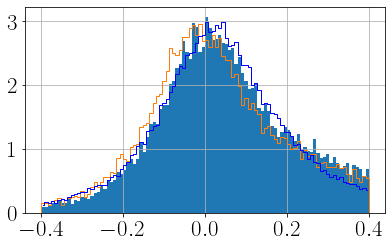

In [1302]:
bins = np.linspace(-.4, .4, 101)
bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
correctDVCS4(epgExpInbFD, 0, -0.6, 0).MM2_ep.hist(bins = np.linspace(-0.4, 0.4, 101), density = True)
epgExpInbFD.MM2_ep.hist(bins = np.linspace(-0.4, 0.4, 101), histtype = 'step', density = True)
simDist_dvpi0, bins = np.histogram(smearingDVCS4(bkgSimInbFD, 0.06, 0, 0).MM2_ep, bins, density = True)
simDist_dvcs, bins = np.histogram(smearingDVCS4(dvcsSimInbFD, 0.06, 0, 0).MM2_ep, bins, density = True)
simDist = (1-contCD)*simDist_dvcs + contCD*simDist_dvpi0
plt.step(bincenters, simDist, where='mid',color='b', linewidth=1)


<AxesSubplot:>

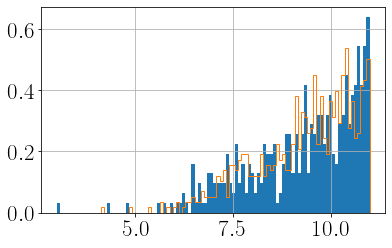

In [1287]:
(epgExpInbFD.Ptheta-0.5).hist(bins = np.linspace(3, 11, 101), density =True)
dvcsSimInbFD.Ptheta.hist(bins = np.linspace(3, 11, 101), density = True, histtype= 'step')


In [ ]:
bins = np.linspace(3, 8, 101)
bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])

(epgExpInbCD.Gp).hist(bins = 101, density = True, histtype = 'step')
(correctDVCS3(epgExpInbCD, 0.004*epgExpInbCD.Gp**2).Gp).hist(bins = bins, density = True, histtype = 'step')
